__Zillow housing data:__

choose the 5 best zip codes to invest in and use predictive modeling with time series

# imports, functions

In [1]:
# import libraries and tools
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pandas_profiling
import datetime
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import pmdarima as pm
%matplotlib inline
plt.style.use('fivethirtyeight')
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from numpy import log
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from math import sqrt
import chart_studio as ply
from matplotlib import pyplot
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

raw_df = pd.read_csv('zillow_data.csv')

import seaborn as sns
#from pandas.plotting import autocorrelation_plot
#from pandas import read_csv
#from datetime import datetime
# import matplotlib
#import matplotlib.dates as mdates
#from itertools import product
#from tqdm import tqdm_notebook
#import cufflinks as cf
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
#import itertools


In [2]:
# amount of times value increases    
def get_increasing_count(df):
    is_dec = df.diff().lt(0).values
    cnt = 265
    #starting_value = df.values[0]
    #result = []
    for i in range(len(is_dec)):
        if is_dec[i]:
            cnt -= 1
    return cnt

In [3]:
# rolling std, mean and adfuller test
def test_stationarity(timeseries, window=12):
    
    # rolling average mean and standard deviation
    # adfuller test with P-value
    rolmean = pd.Series(timeseries).rolling(window=window).mean()
    rolstd = pd.Series(timeseries).rolling(window=window).std()
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    result = adfuller(timeseries)
    print('p-value: %f' % result[1])
    if result[1] <= .05:
        print('timeseries is stationary')
    else:
        print('timeseries is not stationary')

In [4]:
#time series, ACF, PACF, and dist plot
def plot_data_properties(data, lags=12):

    plt.figure(figsize=(16,4))
    plt.plot(data)
    plt.title("Time Series Plot")
    plt.ylabel('Value')
    plt.xlabel('Year')
    fig, axes = plt.subplots(1,3,squeeze=False)
    fig.set_size_inches(16,4)
    plot_acf(data, ax=axes[0,0], lags=lags);
    plot_pacf(data, ax=axes[0,1], lags=lags);
    sns.distplot(data, ax=axes[0,2])
    axes[0,2].set_title("Probability Distribution")

In [5]:
# plot moving average with anomolies
def plot_moving_avg(series, window=12, plot_intervals=True, scale=2, 
                      plot_anomalies=True):

#         series - dataframe with timeseries
#         window - rolling window size 
#         scale= # of std deviations from mean
#         plot_intervals - show confidence intervals
#         plot_anomalies - show anomalies 

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average")
    plt.plot(rolling_mean, "g", label="Rolling mean trend", alpha = 0.5)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond", alpha = 0.5)
        plt.plot(lower_bond, "r--", alpha = 0.5)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10, color='orange')
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [6]:
def arima_results(zip_code):
    global mod
    mod = pm.auto_arima(zip_code)
    results = mod.fit(zip_code)
    print(results.summary())

    results.plot_diagnostics(figsize=(16, 8))
    plt.show();

In [7]:
# mse, mse percent, explained variance score(this function used in auto_sarima)
def model_goodness(test, forecast):
    #mean squared error
    print('square root mean error:',(sqrt(mean_squared_error(test,forecast))))

    # percent MSE
    forecast, test = np.array(forecast), np.array(test)
    print('MSE percent:', (np.mean(np.abs(((forecast - test)/forecast)))) *100)

    #explained variance score
    print('explained variance score:',(explained_variance_score(forecast, test)))

In [112]:
# arima model plot using auto_arima, with MSE score
def auto_arima_tts(zip_code, tts_percent=.85):
    
    global mod
    
    train = zip_code[:int(tts_percent*(len(zip_code)))]
    test = zip_code[int(tts_percent*(len(zip_code))):]
    
    #building the model
    # auto_arima to find best fit for p,d,qs
    mod = pm.auto_arima(zip_code
                        ,start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1,
                         error_action='ignore',  
                         suppress_warnings=True
                         #,stepwise=True
                        )
    results = mod.fit(train)
    
    #create forecast
    forecast = results.predict(n_periods=len(test))
    forecast = pd.DataFrame(forecast,index = test.index,columns=['ds'])
    
    #plot the predictions for validation set
    plt.plot(train, label='actual values(train)')
    plt.plot(test, color='green', label= 'actual values(test)')
    plt.plot(forecast,color='orange',alpha=0.6, label='predicted values')
    plt.title('Train Test Split')
    plt.legend(loc="upper left")
    plt.show();
    
    model_goodness(test, forecast)

In [9]:
# # arima model plot using auto_arima, with MSE score
def auto_sarima(df, n_periods = 24):

    model=pm.auto_arima(df
                        , start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True
                        )
    # Forecast
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.plot(df)
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

    plt.title("SARIMA forecast")
    plt.show()

In [10]:
# fit to fbproph, plot, show 1 year prediction
def fb_proph(zip_code, periods=24):
    global m
    global future
    global forecast
    m = fbprophet.Prophet(interval_width=0.95
                         #, growth = 'linear'
                         ,seasonality_mode='additive'
                         )
    m.fit(zip_code.reset_index())
    future = m.make_future_dataframe(periods=periods, freq='M')
    forecast = m.predict(future)
    display(plot_plotly(m, forecast, xlabel = 'Date', ylabel = 'Price'))
    #display((forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(25).round()))
    global preds
    preds = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(23)

In [11]:
#MAPE score for ARIMA
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(((y_true - y_pred)/y_true))) *100

In [12]:
# get mape score for fbprophet and plot 
def proph_metrics(m, num_days= '730 days'):
    
    df_cv = cross_validation(m
                             , horizon = num_days
                            )
    #df_cv.head()
    df_p = performance_metrics(df_cv)
    #df_p.tail()
    fig = plot_cross_validation_metric(df_cv
                                       , metric='mape'
                                      )
    print(mean_absolute_percentage_error(df_cv.y, df_cv.yhat))
    #display(df_p.tail(12))
    display(df_p[np.mod(np.arange(df_p.index.size),12)!=0])

In [13]:
#plot predicted return if property bought at current value using predictions from fbProphet
def pred_return(cur_val, preds):
    preds.set_index('ds', inplace = True)
    preds['return'] = preds['yhat'] - cur_val
    preds['lower'] = preds['yhat_lower']- cur_val
    preds['upper'] = preds['yhat_upper']- cur_val
    preds.iloc[:, 3:].plot();
    
   # plt.plot(preds)
    plt.plot(preds.iloc[:, 3:])
    plt.fill_between(
        preds.index, 
                 preds['upper'], 
                 preds['lower'], 
                 color='k', alpha=.15)

    plt.title("predicted return")
   # plt.show()

In [14]:
#observed vs. predicted using seasonal decompose trend
def trend(ts):
    decomposition = sm.tsa.seasonal_decompose(ts)
    #fig, ax = plt.subplots();
    plt.figure(figsize=(16,4))
    plt.title("observed values and trend")
    plt.ylabel('Value')
    plt.xlabel('Year')
    #sm.tsa.seasonal_decompose(ts);
    plt.plot(decomposition.trend.index, decomposition.trend, c='red', linewidth=5, alpha= 0.7);
    plt.plot(ts.index, ts, c='blue', linewidth=3);

# explore, scrub

Zillow's housing records data:

In [15]:
df = pd.read_csv('zillow_data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

Data has 272 columns being dates(from 1996-2018), and the rest describing the location, with a total of 14723 records.

In [16]:
# #isolating non-date data for pandas_profiling
pandas_profiling.ProfileReport(df.iloc[:,0:7])

Being somewhat familiar with zip codes, I'm able to identify the RegionName column as zip codes, but unsure of RegionID. 

Curious how the states compare.

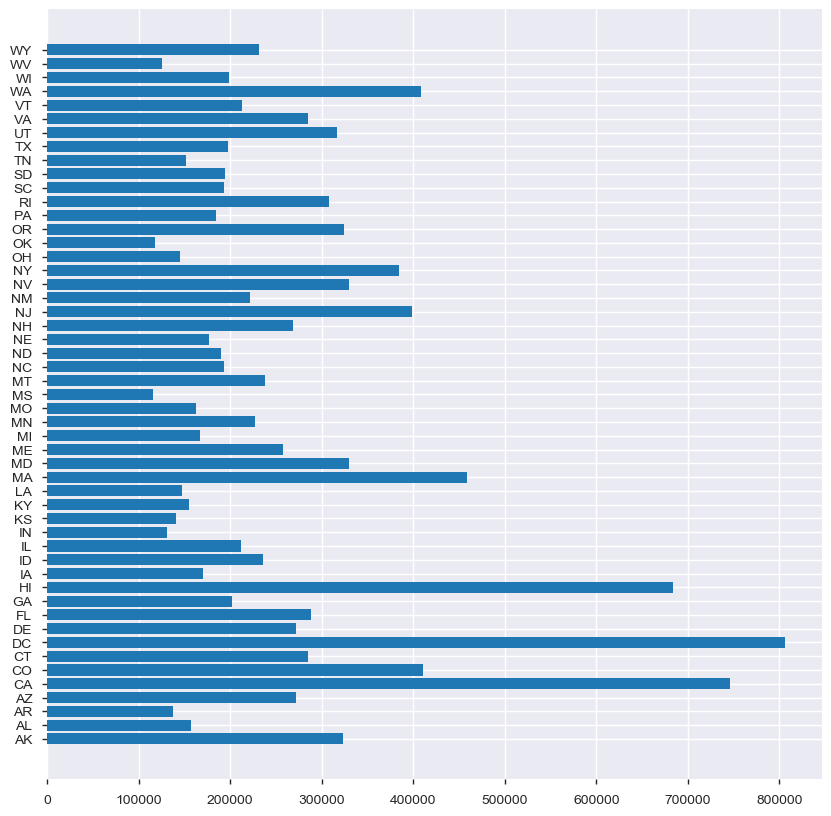

In [17]:
state_avg = raw_df.groupby('State').mean()
plt.figure(figsize=(10,10))
plt.barh(state_avg.index, state_avg['2018-04']);

The locations appear to cover all US states(including D.C.) and cities.\
DC, California, and Hawaii hold the highest average home prices as of 2018, but this doesn't necessarily mean the top zip codes will be amongst those.


The goal is to find the top 5 zip codes, so other columns are removed from df.

In [18]:
#remove unneeded columns
cols_drop = ['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']
df = df.drop(cols_drop, axis=1)

# convert RegionName values to string and as index
df['RegionName'] = df['RegionName'].astype(str)
df.set_index('RegionName', inplace = True)
df.head()

1996-04   1996-05   1996-06   1996-07   1996-08   1996-09  \
RegionName                                                               
60657       334200.0  335400.0  336500.0  337600.0  338500.0  339500.0   
75070       235700.0  236900.0  236700.0  235400.0  233300.0  230600.0   
77494       210400.0  212200.0  212200.0  210700.0  208300.0  205500.0   
60614       498100.0  500900.0  503100.0  504600.0  505500.0  505700.0   
79936        77300.0   77300.0   77300.0   77300.0   77400.0   77500.0   

             1996-10   1996-11   1996-12   1997-01  ...  2017-07  2017-08  \
RegionName                                          ...                     
60657       340400.0  341300.0  342600.0  344400.0  ...  1005500  1007500   
75070       227300.0  223400.0  219600.0  215800.0  ...   308000   310000   
77494       202500.0  199800.0  198300.0  197300.0  ...   321000   320600   
60614       505300.0  504200.0  503600.0  503400.0  ...  1289800  1287700   
79936        77600.0   77700.0   77700.0   77800.0  ...   119100   119400   

            2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  \
RegionName                                                                  
60657       1007800  1009600  1013300  1018700  1024400  1030700  1033800   
75070        312500   314100   315000   316600   318100   319600   321100   
77494        320200   320400   320800   321200   321200   323000   326900   
60614       1287400  1291500  1296600  1299000  1302700  1306400  1308500   
79936        120000   120300   120300   120300   120300   120500   121000   

            2018-04  
RegionName           
60657       1030600  
75070        321800  
77494        329900  
60614       1307000  
79936        121500  

[5 rows x 265 columns]

## Dealing will null values

In [19]:
# check for missing data(percent)
df.isnull().sum().sum()/(14723*272)

0.03917714779996084

It appears there's close to 4% of cells with missing data.

I'd like to avoid eliminating rows with insignificant amounts of missing values if possible.\
Looking at what percentage of rows are missing significant amounts data to see what I'm working with:

In [20]:
for num, perc in zip((0.0, 0.1, 0.25, 0.5, 0.75, 0.9), ('any','10%', '25%','50%', '75%', '90%')) :
    print('\n % of rows with more than',perc,'missing values:')
    len(df[df.isna().mean(axis=1) > num])/ len(df)


 % of rows with more than any missing values:


0.07056985668681655


 % of rows with more than 10% missing values:


0.07036609386673912


 % of rows with more than 25% missing values:


0.07036609386673912


 % of rows with more than 50% missing values:


0.042110982816002174


 % of rows with more than 75% missing values:


0.013991713645316851


 % of rows with more than 90% missing values:


0.0

7 percent of rows are missing more than 1/4 of values. 
I'm curious if the data is missing mostly from the earlier years, later years, or if there are values missing randomly scattered throughout the dataframe, so I can figure out how to manage the null values.\
I might consider using ffill or bfill(or average of ffill + bfill) if the nas are scattered and sparse. 

In [21]:
#rows with any missing data
df[df.isnull().any(axis=1)]

1996-04  1996-05  1996-06  1996-07  1996-08  1996-09  1996-10  \
RegionName                                                                  
10011           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
10456           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
60611           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
11238           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
27834           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
10021           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
58103           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2301            NaN      NaN      NaN      NaN      NaN      NaN      NaN   
67401           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
10014           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
35758           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
58104           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
57106           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
30032           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
58201           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
72764           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
70301           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
30721           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
31061           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
11101           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
49442           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
10459           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
11205           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
30120           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
11217           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
45385           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
46203           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
94608           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
64804           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
35630           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
...             ...      ...      ...      ...      ...      ...      ...   
44449           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
24325           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
72845           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
58042           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
66956           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
33855           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
19964           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
62440           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
67070           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
37141           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
93664           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
66023           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
31561           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
43013           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
56041           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
57035           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
49638           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
56010           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
68633           NaN      NaN      NaN      NaN      NaN      NaN      NaN   
93529   

There are 1039 rows with nas, and it looks like the missing values are primarily, if not all, in the earlier months of the time series.\
What if I were to limit data to the most recent 15 or even 10 years?

In [22]:
# rows missing data after 2004
len(df.iloc[:,108:][df.iloc[:,108:].isnull().any(axis=1)])
# rows missing after 2008
len(df.iloc[:,168:][df.iloc[:,168:].isnull().any(axis=1)])

801

349

Even excluding half of the time span doesn't eliminate the nas to, so I may need to figure something else out.

I'm still hesitant to drop so many rows. Some of the rows with missing data end with pretty high values, therefore may be considered as one of the top zip codes for investment. There's less risk of missing one of the 'better' zip codes if only dropping the lower priced ones.


Looking at the percentiles of current zip code values and recent value increases could help establish a cut off point for zip codes included in the consideration for top 5:

In [23]:
# values as of 2018-04
print('prices in 2018:')
round(df['2018-04'].describe())

# price difference between 2018-2011
print('return from 2011 to 2018:')
round((df['2018-04']-df['2011-04']).describe())

prices in 2018:


count       14723.0
mean       288040.0
std        372054.0
min         13800.0
25%        132400.0
50%        198100.0
75%        321100.0
max      17894900.0
Name: 2018-04, dtype: float64

return from 2011 to 2018:


count      14448.0
mean       85424.0
std       163470.0
min      -155200.0
25%        20700.0
50%        43800.0
75%        94625.0
max      5080300.0
dtype: float64

Since we're wanting to find zip codes with potential for high return, I'm going to check how many of the rows with nans have a return higher than the lower 75% as those would be more likely qualified as top zip codes.

In [24]:
# how many rows with a positive difference between 2011 to 2018 over 75% contain null values 
df_nas = df[df.isnull().any(axis=1)]
len(df_nas[(df_nas['2018-04']-df_nas['2011-04'])>94625])

60

Only 60 of the zip codes with null values show a return of more than the top 75% in the last 7 years. 

In [25]:
# how many of the top roughly 10% priced zip codes are going to be excluded if I drop nas
top_140 = df.sort_values(by='2018-04', ascending=False).head(140)
pd.merge(top_140, df_nas, indicator=True)

1996-04  1996-05  1996-06  1996-07  1996-08  1996-09  1996-10  1996-11  \
0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
5      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
7      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
8      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
9      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

   1996-12  1997-01  ...   2017-08   2017-09   2017-10   2017-11   2017-12  \
0      NaN      NaN  ...  18703500  18605300  18569400  18428800  18307100   
1      NaN      NaN  ...  12112600  12036600  12050100  12016300  11946500   
2      NaN      NaN  ...   9958800   9828700   9631000   9515800   9492800   
3      NaN      NaN  ...   3442900   3443800   3426000   3407000   3404100   
4      NaN      NaN  ...   2946300   2958800   2965400   2964400   2961600   
5      NaN      NaN  ...   2696700   2716500   2724000   2744300   2768900   
6      NaN      NaN  ...   2338800   2344700   2359500   2403900   2435600   
7      NaN      NaN  ...   2230800   2226800   2241400   2248400   2251000   
8      NaN      NaN  ...   1995600   2031100   2049600   2057800   2064500   
9      NaN      NaN  ...   1599100   1628600   1647300   1660400   1670800   

    2018-01   2018-02   2018-03   2018-04  _merge  
0  18365900  18530400  18337700  17894900    both  
1  11978100  11849300  11563000  11478300    both  
2   9524900   9373400   9119600   8959300    both  
3   3413800   3482900   3588100   3656000    both  
4   2965300   2974000   3004000   3044500    both  
5   2810700   2848100   2869600   2885300    both  
6   2451700   2455200   2455800   2440000    both  
7   2251600   2245300   2243700   2248400    both  
8   2037600   2056900   2106500   2136500    both  
9   1683400   1696900   1711400   1723800    both  

[10 rows x 266 columns]

In [26]:
merged_df= pd.merge(top_140, df_nas, indicator=True)
merged_df['2018-04']-merged_df['2008-04']

0    7509300.0
1    5728400.0
2    3156600.0
3    2036500.0
4    1567800.0
5    1599600.0
6    -454400.0
7     837200.0
8          NaN
9          NaN
dtype: float64

I'll be dropping 10 of the top 140 priced homes due to the nas, and the top 5 of those with increases in values over 1M. This shouldn't be ignored when sharing the results of my analysis.

If returned to at a later time, I'd like to find a reasonable way to include these in the analysis, which could mean narrowing the time span, but there are lots of different ways I could deal with the null values, and ideally I would go to a domain expert to provide some insight that would help me make the right decision. 

In [27]:
#drop all rows with null values
df= df.dropna()

# choose zip codes

Investors will likely be interested in properties that promise high return, and lower risk. 

To choose which 5 zip codes would be best to invest in, I'll be using a score that takes into account the overall increase in value over the full 22 years of data, and also within the last 5 years, which will put more weight on the more recent values.

To measure risk/volatility, I take a count of how many times the price has increased over the 269 months of records. Zip codes whose home values have dropped more frequently, regardless of by what amount, will be given a lesser score than those that consistently rise. 

In [28]:
# how many times(months) the values have increased from the previous months value
#(as opposed to dropping or remaining the same) as a measure of resiliency
df['ups'] = df.iloc[:,1:].apply(lambda row: get_increasing_count(row), axis=1)

# increase in value over full 22 years
df['diff'] = df['2018-04']- df['1996-04']

# increase in last 5 years
df['5_yr'] = df['2018-04']- df['2013-04']

In [29]:
round(df.iloc[:,-4:].describe())

2018-04      ups       diff       5_yr
count    13684.0  13684.0    13684.0    13684.0
mean    293868.0    189.0   175568.0    78895.0
std     325706.0     16.0   256037.0   122408.0
min      13800.0    110.0  -289900.0   -46100.0
25%     137100.0    179.0    62700.0    22900.0
50%     205600.0    190.0   106000.0    46000.0
75%     332325.0    200.0   190000.0    89425.0
max    7386600.0    240.0  5617300.0  2809600.0

The top 25% of return rate on the past five years was over 89,000. Limiting the zip codes to those with over 90,000 5 yr return seems reasonable.

In [30]:
#limiting data to homes increasing higher than 10k/y for last 5 yrs
df = df[df['5_yr'] > 90000]

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3386 entries, 60657 to 89155
Columns: 268 entries, 1996-04 to 5_yr
dtypes: float64(221), int64(47)
memory usage: 6.9+ MB


In [32]:
#scaling metrics to use as overall score( all on 0-1 scale)
df[['diff', '5_yr', 'ups']] = scaler.fit_transform(df[['diff', '5_yr', 'ups']])

# creating score column to choose highest ranked zip codes
df['score']= df[['ups', 'diff', '5_yr']].sum(axis=1)/3

In [33]:
# save data as top 5 zip codes using created scores
z_df = df.sort_values('score',ascending = False)
z_df.head()

1996-04    1996-05    1996-06    1996-07    1996-08    1996-09  \
RegionName                                                                     
94027       1179200.0  1184300.0  1189700.0  1195400.0  1201200.0  1207300.0   
90210       1015400.0  1016900.0  1018400.0  1019800.0  1021400.0  1023400.0   
94301        709500.0   711900.0   715000.0   719000.0   723900.0   729800.0   
33480        958400.0   958100.0   957900.0   957800.0   958000.0   958400.0   
94022        795600.0   798400.0   801700.0   805400.0   809600.0   814400.0   

              1996-10    1996-11    1996-12    1997-01  ...  2017-11  2017-12  \
RegionName                                              ...                     
94027       1214100.0  1221200.0  1230900.0  1242600.0  ...  6429100  6581800   
90210       1026300.0  1029900.0  1035500.0  1042800.0  ...  5574100  5661000   
94301        736900.0   745200.0   755100.0   766500.0  ...  4481700  4544700   
33480        959500.0   961100.0   964200.0   968700.0  ...  4588200  4609000   
94022        820200.0   826900.0   835600.0   846000.0  ...  4045200  4118000   

            2018-01  2018-02  2018-03  2018-04       ups      diff      5_yr  \
RegionName                                                                     
94027       6705000  6764600  6788400  6796500  0.638095  1.000000  1.000000   
90210       5738200  5816100  5907800  5956700  0.790476  0.885563  0.917448   
94301       4595100  4668700  4762600  4818400  0.600000  0.744651  0.763155   
33480       4626500  4661200  4692300  4686200  0.714286  0.680136  0.628976   
94022       4170500  4235700  4321900  4372600  0.600000  0.654608  0.678029   

               score  
RegionName            
94027       0.879365  
90210       0.864496  
94301       0.702602  
33480       0.674466  
94022       0.644212  

[5 rows x 269 columns]

# reshape/ assign zips

To prepare the data for modeling and further analysis, it's ideal that the scoring data will be excluded from further processes and will need to be flipped 90 degrees(transposed) so that the dates are the index and zip codes are the columns. 

In [34]:
#remove unneeded columns
z_df = z_df.iloc[:,:-4]

In [35]:
#transpose data(flip to set dates as index, zip codes as columns)
z_df = z_df.T
# #covert index to datetime, 
z_df.index = pd.to_datetime(z_df.index)
#z_df = z_df.astype(int)
z_df.head()
z_df.tail()

RegionName      94027      90210     94301     33480     94022     94123  \
1996-04-01  1179200.0  1015400.0  709500.0  958400.0  795600.0  849100.0   
1996-05-01  1184300.0  1016900.0  711900.0  958100.0  798400.0  859000.0   
1996-06-01  1189700.0  1018400.0  715000.0  957900.0  801700.0  868800.0   
1996-07-01  1195400.0  1019800.0  719000.0  957800.0  805400.0  878400.0   
1996-08-01  1201200.0  1021400.0  723900.0  958000.0  809600.0  887800.0   

RegionName     11975     90402     11976     90020  ...     95482     95536  \
1996-04-01  349500.0  880000.0  400000.0  711600.0  ...  266300.0  158900.0   
1996-05-01  352100.0  881400.0  402700.0  717100.0  ...  264700.0  157500.0   
1996-06-01  354900.0  882700.0  405700.0  722400.0  ...  263300.0  155800.0   
1996-07-01  358100.0  883800.0  408900.0  727500.0  ...  262100.0  154000.0   
1996-08-01  361600.0  885000.0  412600.0  732700.0  ...  261200.0  152100.0   

RegionName     77025     95437     97495     95901     95485     95445  \
1996-04-01  477600.0  323400.0  186100.0  132700.0  155500.0  324300.0   
1996-05-01  482100.0  318600.0  186700.0  132200.0  153000.0  322100.0   
1996-06-01  486600.0  313500.0  187000.0  131600.0  150400.0  320000.0   
1996-07-01  490900.0  308300.0  186900.0  130700.0  147800.0  317800.0   
1996-08-01  494800.0  303000.0  186800.0  129600.0  145300.0  315500.0   

RegionName     95961     78735  
1996-04-01  134900.0  772100.0  
1996-05-01  135000.0  765800.0  
1996-06-01  134800.0  760200.0  
1996-07-01  134300.0  755200.0  
1996-08-01  133800.0  751100.0  

[5 rows x 3386 columns]

RegionName      94027      90210      94301      33480      94022      94123  \
2017-12-01  6581800.0  5661000.0  4544700.0  4609000.0  4118000.0  4579000.0   
2018-01-01  6705000.0  5738200.0  4595100.0  4626500.0  4170500.0  4582000.0   
2018-02-01  6764600.0  5816100.0  4668700.0  4661200.0  4235700.0  4597600.0   
2018-03-01  6788400.0  5907800.0  4762600.0  4692300.0  4321900.0  4640200.0   
2018-04-01  6796500.0  5956700.0  4818400.0  4686200.0  4372600.0  4682300.0   

RegionName      11975      90402      11976      90020  ...     95482  \
2017-12-01  3317200.0  4089200.0  3158200.0  3730900.0  ...  337300.0   
2018-01-01  3353000.0  4125000.0  3176000.0  3760500.0  ...  338700.0   
2018-02-01  3425000.0  4152300.0  3207400.0  3785500.0  ...  339600.0   
2018-03-01  3473300.0  4169700.0  3233700.0  3819900.0  ...  340100.0   
2018-04-01  3467800.0  4179000.0  3241400.0  3842700.0  ...  340500.0   

RegionName     95536     77025     95437     97495     95901     95485  \
2017-12-01  333100.0  459300.0  359100.0  347700.0  234300.0  258200.0   
2018-01-01  335800.0  461200.0  358500.0  347300.0  236900.0  261000.0   
2018-02-01  337300.0  460700.0  358300.0  347700.0  239100.0  265300.0   
2018-03-01  342600.0  455400.0  359200.0  349900.0  240400.0  271000.0   
2018-04-01  348700.0  449400.0  360500.0  351900.0  240400.0  275000.0   

RegionName     95445     95961     78735  
2017-12-01  417700.0  239100.0  473200.0  
2018-01-01  416000.0  241200.0  473500.0  
2018-02-01  416400.0  243700.0  475500.0  
2018-03-01  415300.0  246600.0  479300.0  
2018-04-01  414000.0  248600.0  482200.0  

[5 rows x 3386 columns]

# prep data columns

In [36]:
# assigning zip codes to variables in descending order of "best"
zip_1 = z_df[['94027']].copy()
zip_2 = z_df[['90210']].copy()
zip_3 = z_df[['94301']].copy()
zip_4 = z_df[['33480']].copy()
zip_5 = z_df[['94022']].copy()

# average to compare to top zip codes
z_df['us_avg'] = z_df.mean(axis=1)
zcs = zip_1, zip_2, zip_3, zip_4, zip_5

In [37]:
#raw_df.iloc[:, 7:].mean().plot(figsize=(12,6));

Looking at how the chosen zip codes compare the the National average

<Figure size 800x550 with 0 Axes>

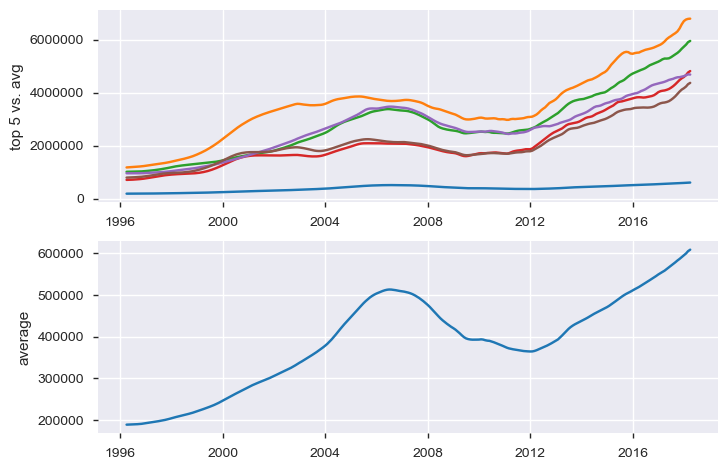

In [38]:

plt.figure()
f, axes = plt.subplots(2, 1);

axes[0].plot(z_df[['us_avg','94027', '90210', '94301', '33480', '94022']]);
axes[0].set_ylabel('top 5 vs. avg');
axes[1].plot(z_df['us_avg'].index, z_df['us_avg']);
axes[1].set_ylabel('average');





To use fbprophet further along, the columns will need to be named 'ds' and 'y'. Using simpler variables make management easier with other things as well so I'll do that now.

In [39]:
# rename columns 'ds' and 'y'(as required for fbprophet, w)
for zc in (zcs):
    zc.index.names = ['ds']
    zc.columns = ['y']
    #zc.reset_index(inplace=True)

# explore/model

### arima the long way- making stationary and fitting

ARIMA models are often used with time series, as they integrate several simpler models into something more complex. The rolling mean, autocorrelation, and seasonality are taken into account to create more robust, quality predictions than using just one of the more naive approaches alone. 

To manually fit a arima model, the data must meet certain assumptions, one being that it is stationary- the rolling mean and rolling standard deviation, and the time series, need to be free of trends. 

In [40]:
#log function helps make data stationary
zc_1 = np.log(zip_1)

In [41]:
#double differencing was needed on this dataset to be transformed to stationary
zc_1= zc_1.diff().diff()

In [42]:
# with differencing, you lose the first value of data
zc_1.dropna(inplace=True)

the adfuller test defaults with an alpha of 0.5, a p-value under 0.5 indicates data is stationary

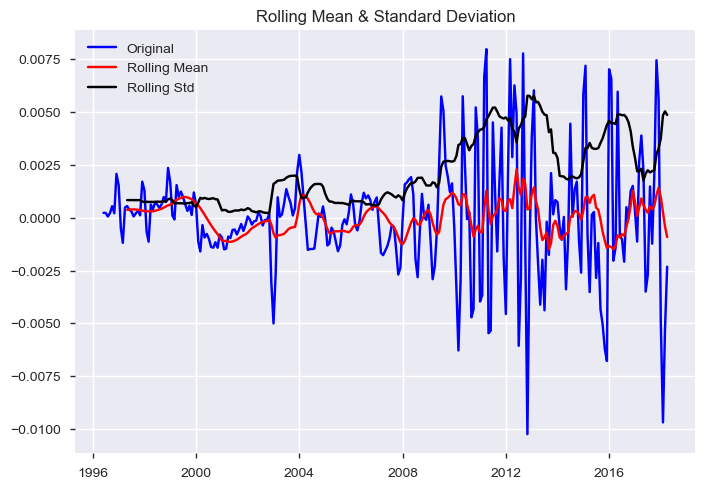

p-value: 0.000004
timeseries is stationary


In [43]:
# plotting series, rolling mean and standard deviation, follwed by adfuller test.
test_stationarity(zc_1.y)

To find the right order for the ARIMA model, we need to find what values to fill for p,d, and q. (For SARIMA:  p,d,q,P,D,Q,s) These are determined based on the autocorrelation, partial autocorrelation, and number of times data was differenced before transformed to stationary.

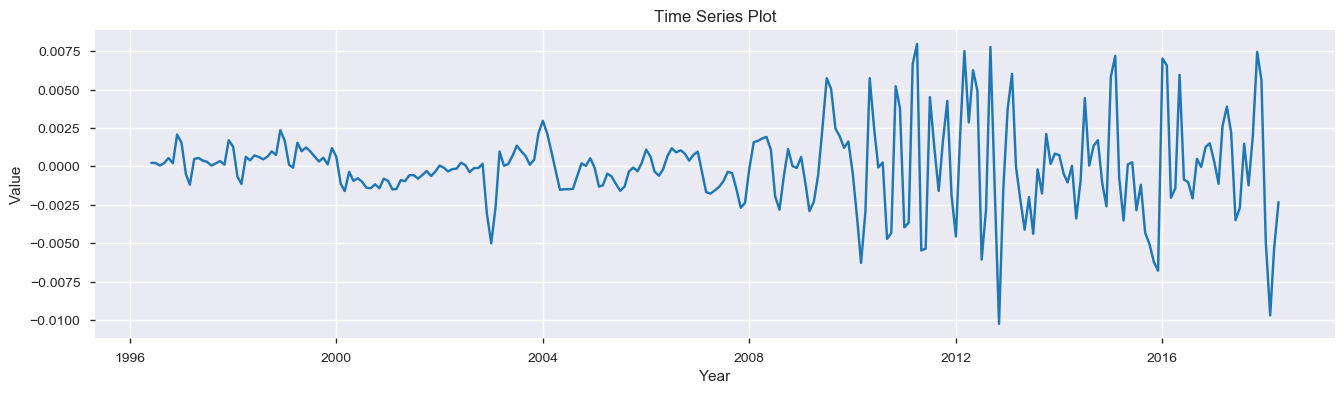

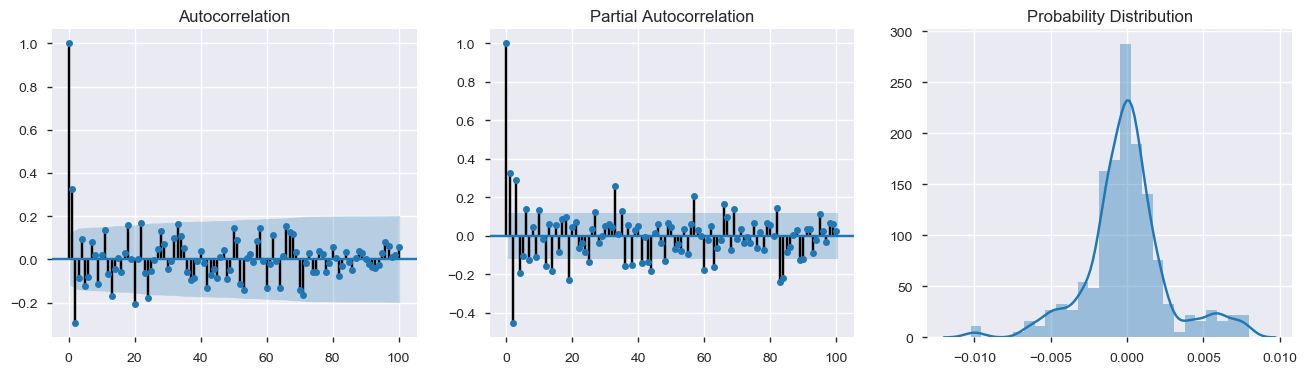

In [44]:
plot_data_properties(zc_1, 100)

for p- we look at the autocorrelation plot. The at 0, the value is at it's most extreme, with all other values falling more closely within the shaded region. So p will be 0.

for d- we use 2, as the data was twice differenced before reaching stationarity.

for q- looking at the partial autocorrelation plot, the first line- at zero, is once again most extreme.

So in this case, I would likely use order: 0,2,0. Adding seasonality might be helpful, too.

I could put more effort into finding for myself the right fit for the SARIMA, but from my few experiences have found the auto_arima tool provided by pyramid python library does a much better job at avoiding under or overfitting, and it's just easier.

Below is what I had originally used to fit with the first zip code, but it didn't turn out to be a good fit.

In [45]:
mod = sm.tsa.statespace.SARIMAX(zip_1
                                ,order=(0, 2, 0)
                                ,seasonal_order=(0, 2, 3, 12)
                               )
results = mod.fit()
print(results.summary())

/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(0, 2, 0)x(0, 2, 3, 12)   Log Likelihood               -2733.215
Date:                            Thu, 24 Oct 2019   AIC                           5474.430
Time:                                    22:59:52   BIC                           5488.336
Sample:                                04-01-1996   HQIC                          5480.034
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -1.0960      0.186     -5.895      0.000      -1.460      -0.732
ma.S.L24       0.2366      0.168   

For a well fit model, you'll want to see a low AIC, and p values below 0.05, ideally. The above may not be the best fit, but for further modeling, I'll be using an automated process.

## zip 94027

Looking at seasonal decompose will show the actual data, trend, seasonality, and residual. Although the models can show the trends and predictions, sometimes these plots will provide additional insight as to how they may perform(or under perform) and what potential complications may be expected.

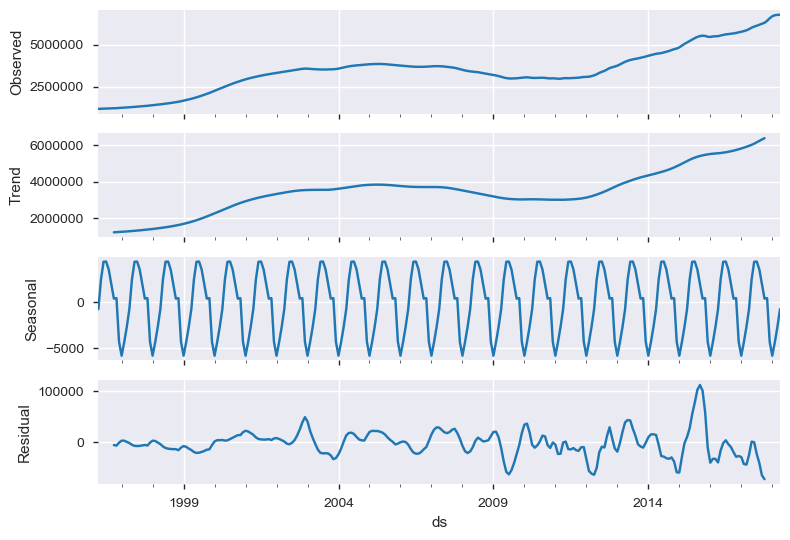

In [46]:
seasonal_decompose(zip_1).plot();

There appears to be seasonality, with one peak per year, and the residuals are greater towards the more recent years.

___
One of the approaches that's integrated in ARIMA, is the rolling average. 
The moving average is a naive approach, using the rolling average of past values to predict the future ones. Despite the simplicity, it plays a part when creating more complex models. Below, the actual values are plotted, alongside the rolling mean trend, based on a 12 period window(12 months). The anomalies, or the values that lie under or over 1 standard deviations from the rolling mean, are indicated in yellow.

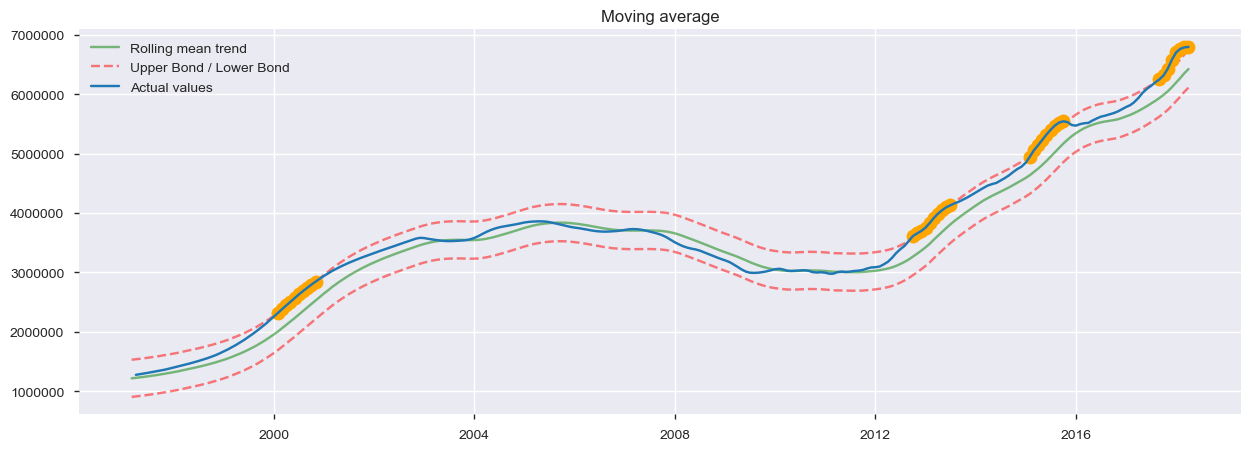

In [47]:
plot_moving_avg(zip_1, window = 12, scale=1)

Most values seem to fit the rolling mean model, although there are increases in some time periods that lie outside the set bounds, especially following the dip between around 2006 and 2011. I would expect to see a similar trend with the other zip codes as well, due to the historical economic events.
___


Although the appropriate values to fit the ARIMA model can be found by making the data stationary and looking at the autocorrelation and partial autocorrelation, and taking into account how many times the data was differenced to be transformed to stationary, and the seasonality factor, the pyramid-arima library offers the convenience of auto_arima. The p,d,q, P, D, Q, and S(or if SARIMA instead of ARIMA) will be used at all are all determined without the need to transform the data or evaluate any plots. 



You can see from the diagnostics that the model fits the appropriate assumptions:

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2839.811
Date:                Thu, 24 Oct 2019   AIC                           5683.622
Time:                        22:59:55   BIC                           5690.767
Sample:                             0   HQIC                          5686.493
                                - 265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.4068    730.459      0.016      0.988   -1420.266    1443.080
sigma2      1.401e+08   6.25e+06     22.400      0.000    1.28e+08    1.52e+08
Ljung-Box (Q):                      155.45   Jarque-

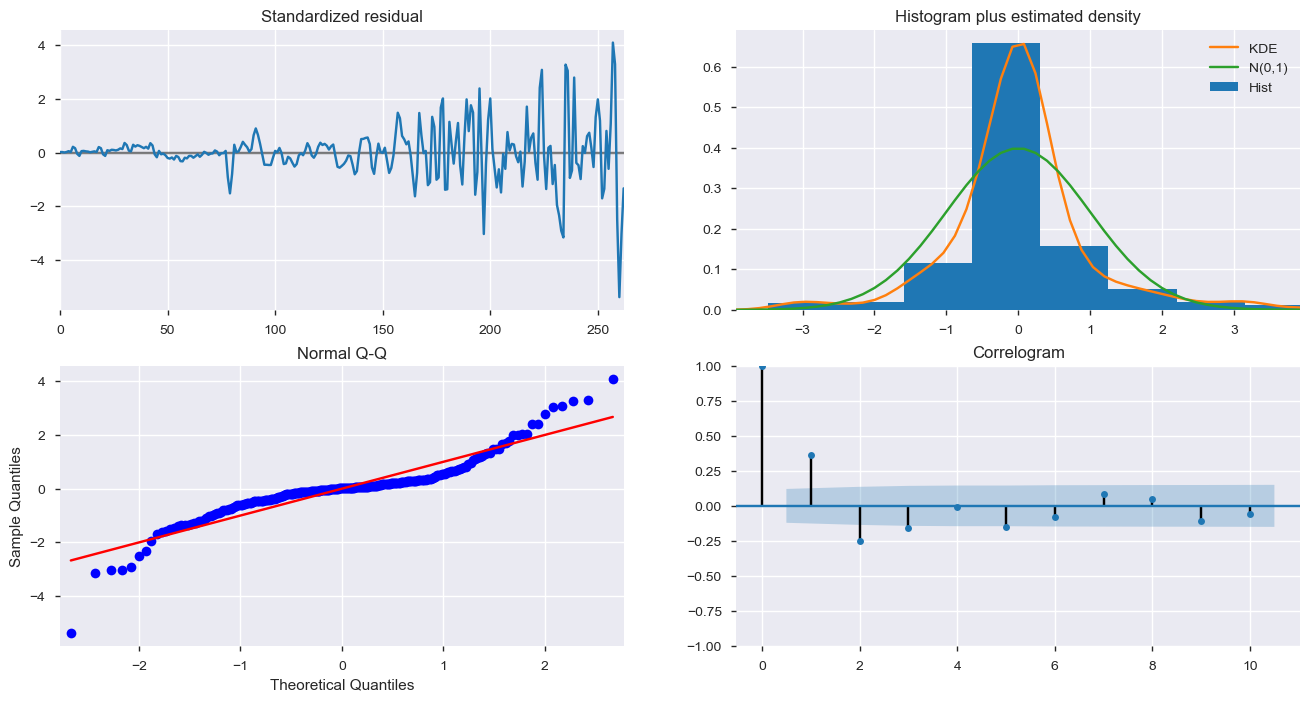

In [48]:
arima_results(zip_1.y)

Using 85% of data as train, and 15% as test, the below plot shows the predicted and actual values, followed by the square root mean error, mean squared percentage error, and explained variance score. A square root mean error and mean squared percentage error closer to 0 is considered more effective. The explained variance score should be closer to 1 to indicate a well performing model.

In [ ]:
auto_arima_tts(zip_1)

A 2.4% mean squared error is good and the model appears to fit well, without overfitting.

___
Using Sarima to forecast future 2 years:

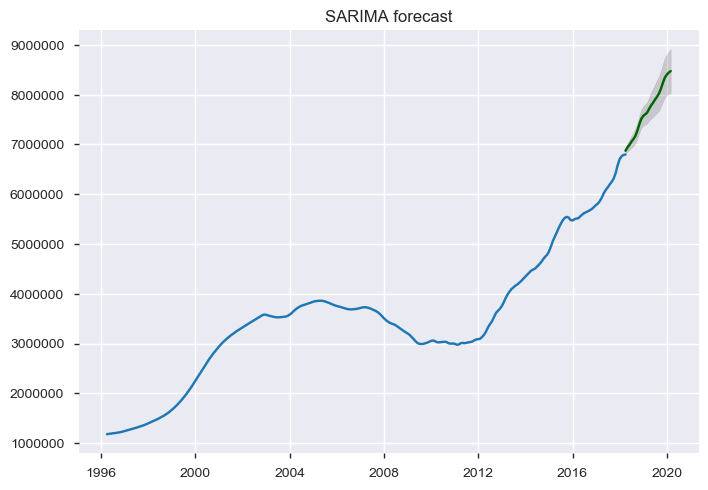

In [50]:
auto_sarima(zip_1)

The projection shows the value may possibly increase by roughly 1.5M in 2 years. Even looking at the lower set interval, it looks fairly certain that there will be an aggressive increase.

## zip 90210

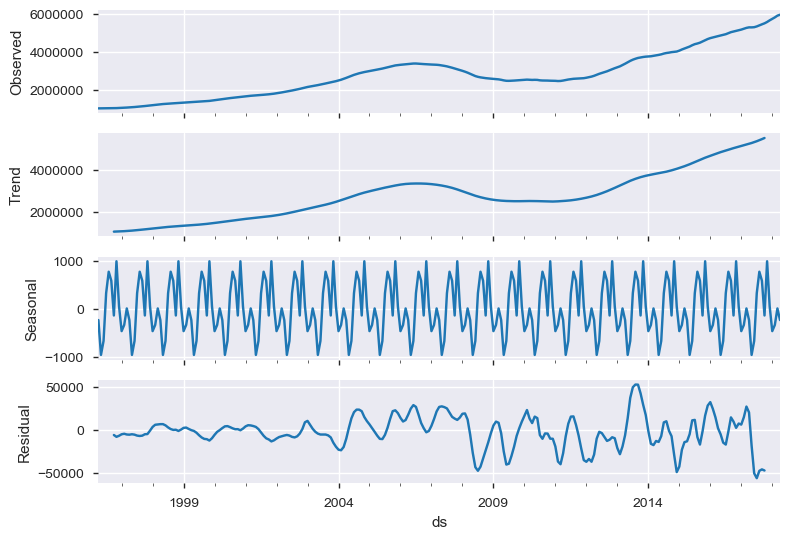

In [51]:
seasonal_decompose(zip_2).plot();

The seasonality on this one is even more dynamic than the previous zip code, the more dramatic variations could mean there's more than one major value increase per year. The residuals also increase notably around 2008, something that may show similar across all of the US zipcodes. This may make it more difficult for the model to find a more narrow prediction interval.

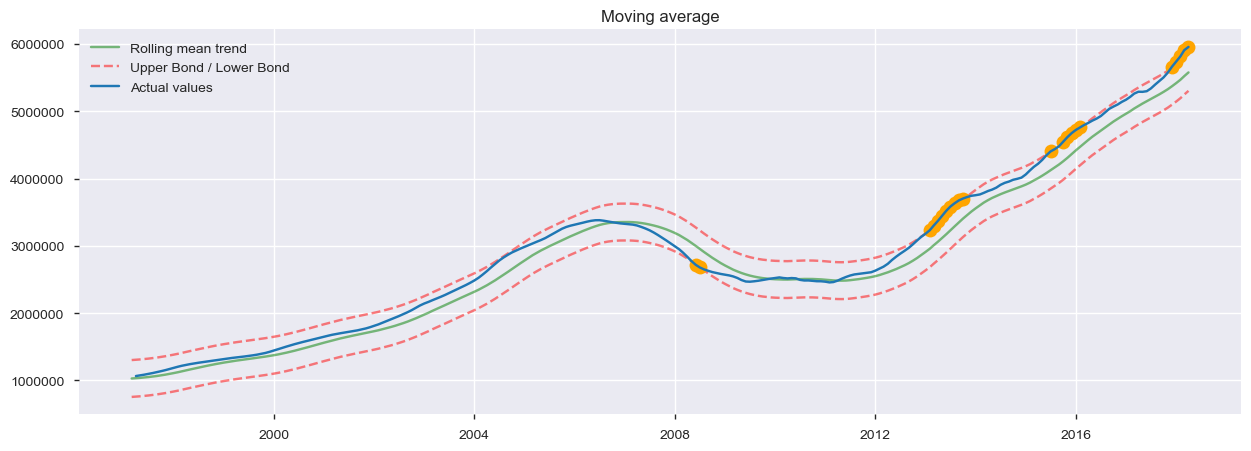

In [52]:
plot_moving_avg(zip_2, 12, scale = 1)

The rolling average model is a fairly good fit here again, with more aggressive increases following 2012, consistent with the seasonal decompose residuals .

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2734.526
Date:                Thu, 24 Oct 2019   AIC                           5473.052
Time:                        23:01:42   BIC                           5480.197
Sample:                             0   HQIC                          5475.923
                                - 265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    180.2281    492.019      0.366      0.714    -784.111    1144.567
sigma2       6.29e+07   2.95e+06     21.332      0.000    5.71e+07    6.87e+07
Ljung-Box (Q):                       98.86   Jarque-

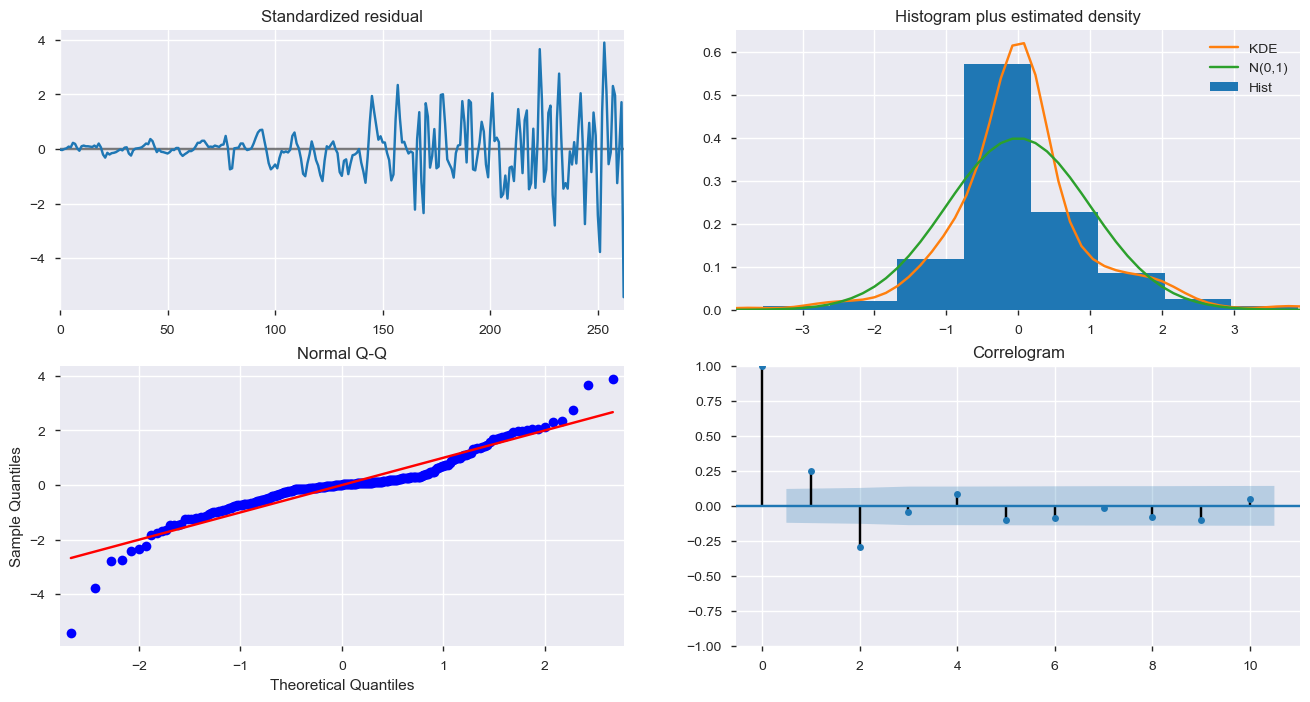

In [53]:
arima_results(zip_2)

The auto arima fit looks good, although the QQ plot indicates there may be some outliers.

Below I will be using 75% of data for training instead of the 85% default I had set, as this model performs poorly with using the 85/15% split. Often, a 75% split is used for train test splits, but because of the unusual dip about half way through the time series, most models performed better with a larger training set. So I find it interesting that the larger train set here didn't prove to be advantageous. 

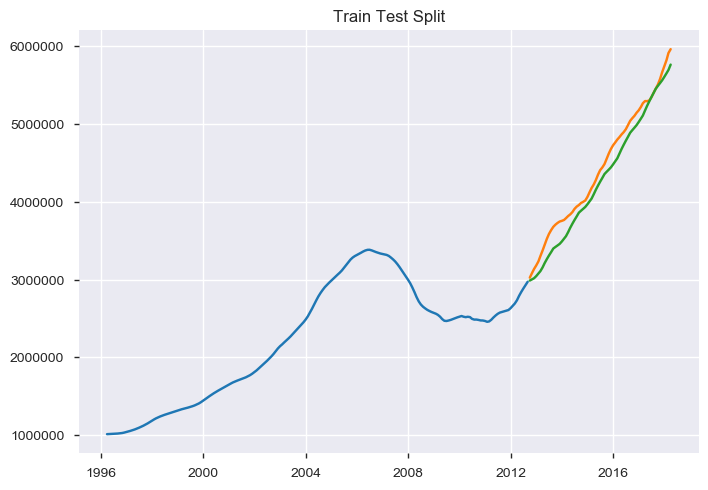

square root mean error: 174067.6865023666
MSE percent: 3.9474824956072205
explained variance score: 0.9917463907292314


In [56]:
auto_arima_tts(zip_2, .75)

The train test split performed well, with an MSE of 4% an explained variance of .99.  
(using the 85%, the MSE was 9%, and explained variance .62)

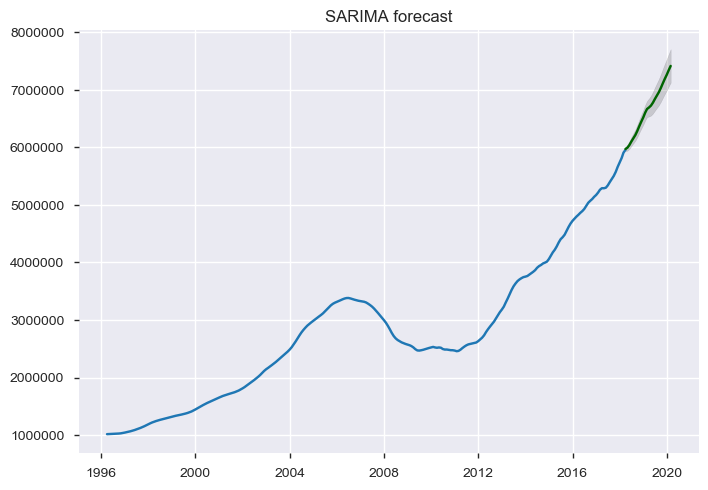

In [57]:
auto_sarima(zip_2)

The prediction shows an increase of nearly 1.5M over the 2 year forecast. Even at the lower end of the interval, the value appears to increase significantly.

## zip 94301

In [58]:
#plot_data_properties(zip_3)

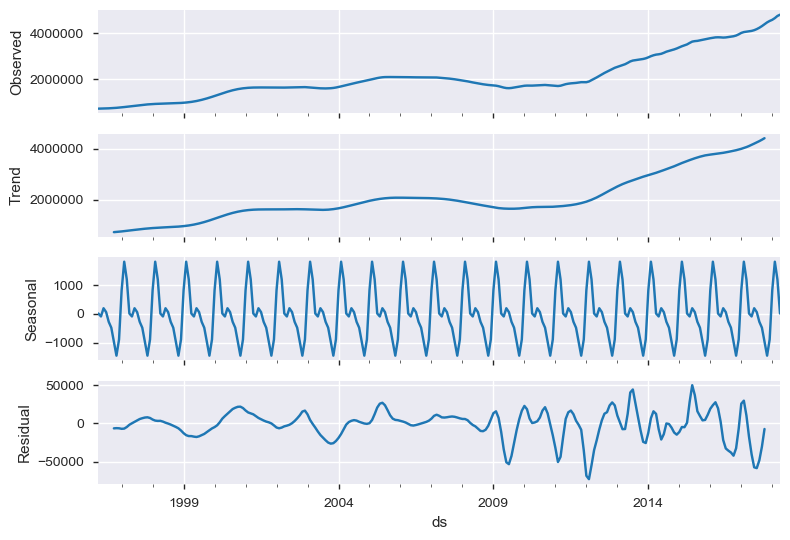

In [59]:
seasonal_decompose(zip_3).plot();

Nothing out of the ordinary here. The seasonality shows a major peak, as well as a minor one following shortly before dropping again. And residuals remain fairly consistent with previous zipcodes.

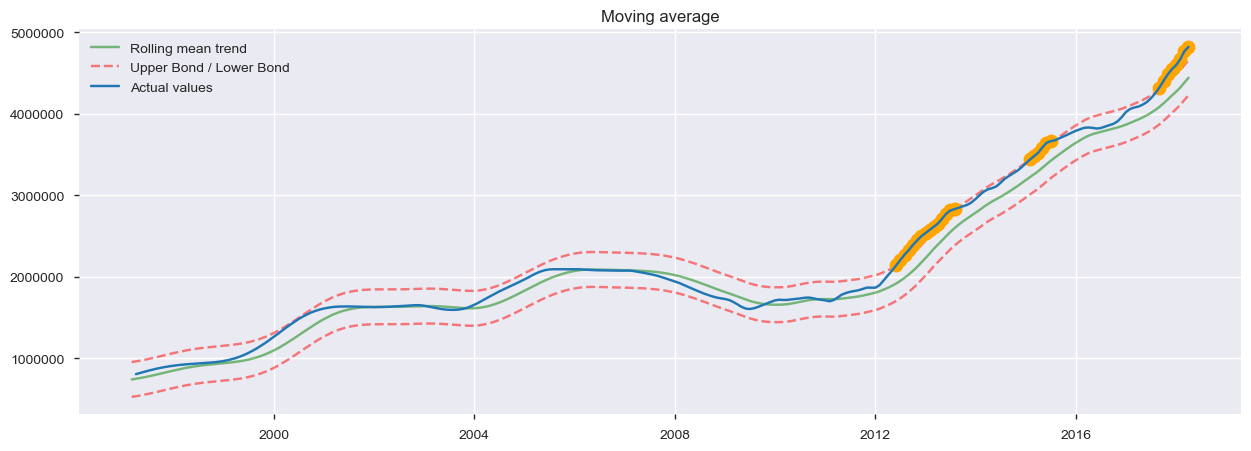

In [60]:
plot_moving_avg(zip_3, window=12, scale= 1)

No anomalies were seen until an aggressive climb after 2012, in the above. If it follows the recent trend, it looks promising for this zip code.

/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2740.142
Date:                Thu, 24 Oct 2019   AIC                           5484.284
Time:                        23:08:20   BIC                           5491.428
Sample:                             0   HQIC                          5487.155
                                - 265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    203.0418    502.721      0.404      0.686    -782.274    1188.357
sigma2      6.564e+07   3.01e+06     21.805      0.000    5.97e+07    7.15e+07
Ljung-Box (Q):                      254.41   Jarque-

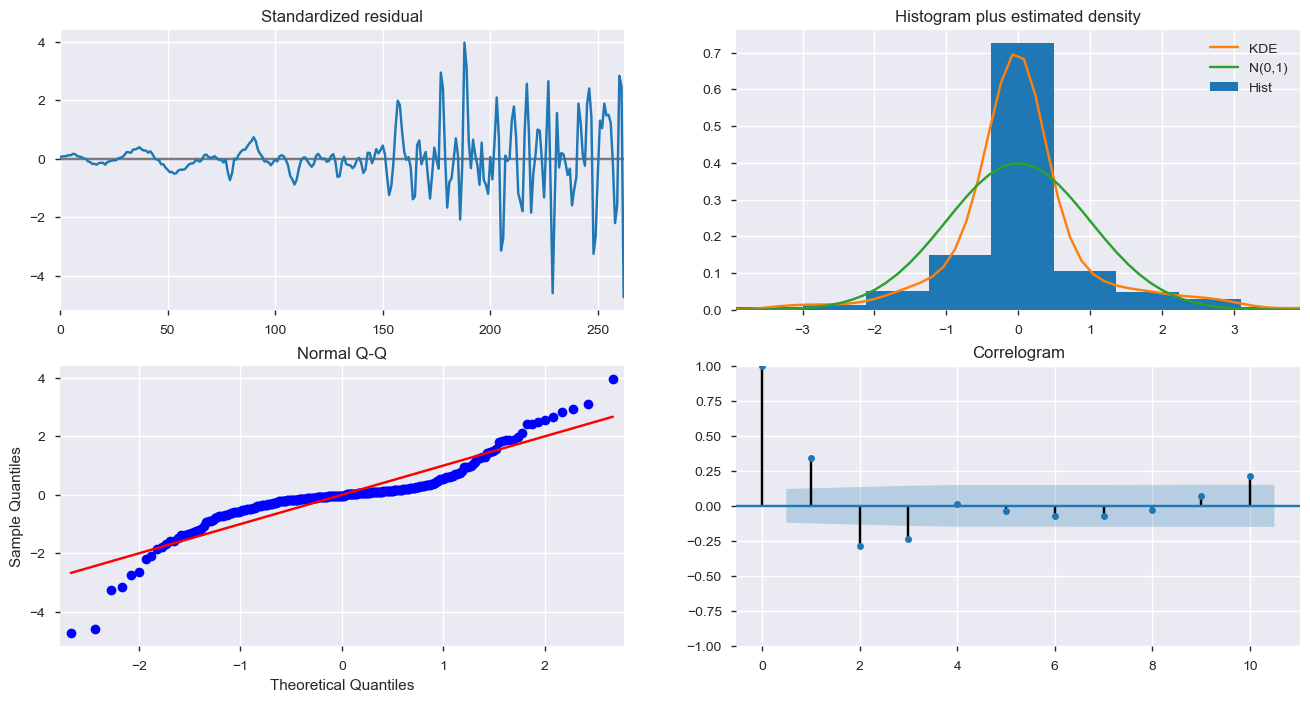

In [61]:
arima_results(zip_3)

Data appears to fit assumptions, and the P value is below 0.05, which indicates a good fit. Although the distribution looks very normal, the QQ plot shows there could be some outliers.

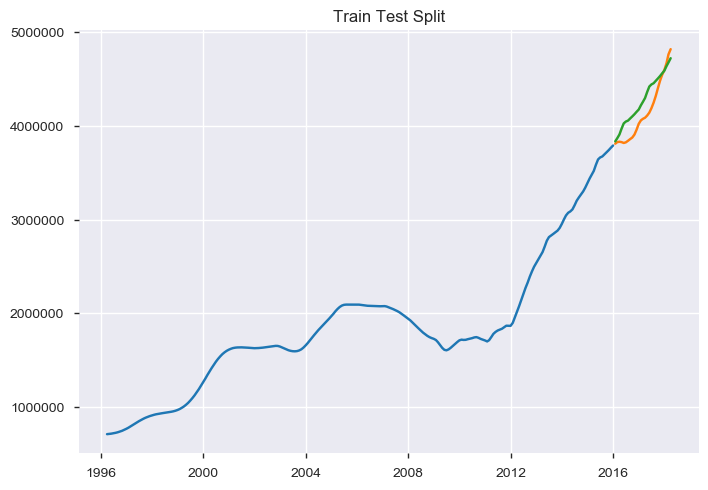

square root mean error: 170186.74396879668
MSE percent: 3.5233241377813633
explained variance score: 0.830476608372686


In [105]:
auto_arima_tts(zip_3, .9)

The MSE is a little higher than som

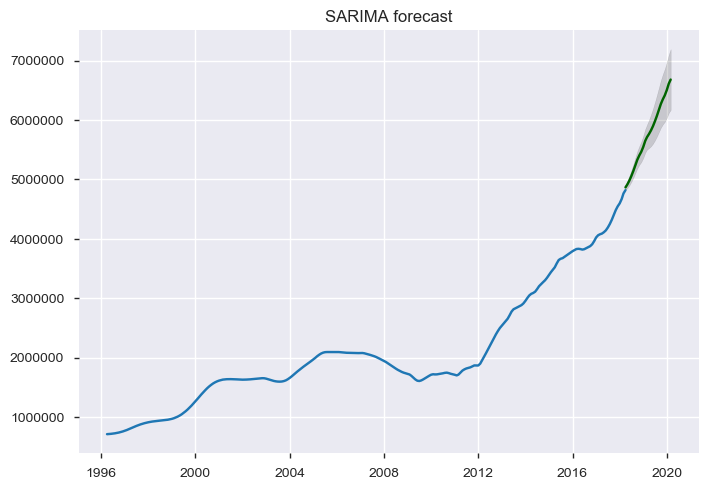

In [63]:
auto_sarima(zip_3)

A 1M-2M increase seems to be the trend with the chosen zip codes as well, and though the prediction interval widens with time, as is to be expected, it remains to suggest a substantial increase, even at the lower end.

## zip 33480

In [64]:
#plot_data_properties(zip_4)

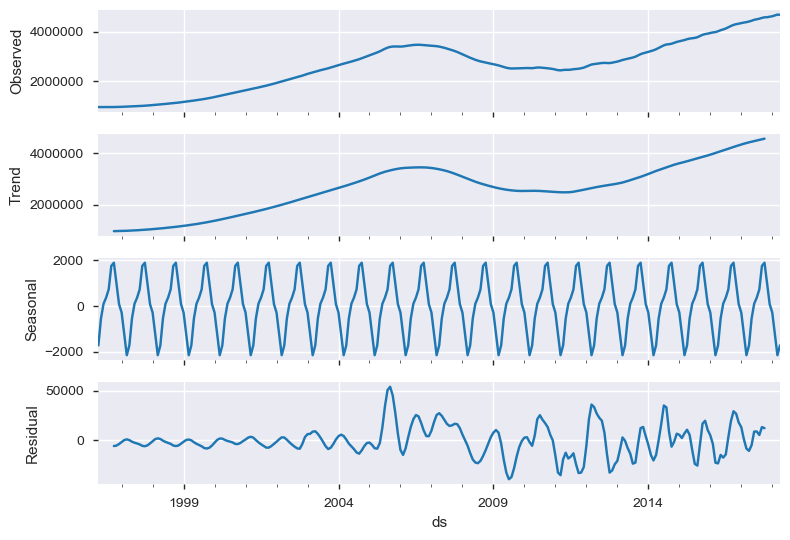

In [65]:
seasonal_decompose(zip_4).plot();

There's just one clear seasonal peak per year, and interestingly, although the residuals widen half way through, it seems they begin to narrow more towards the end.

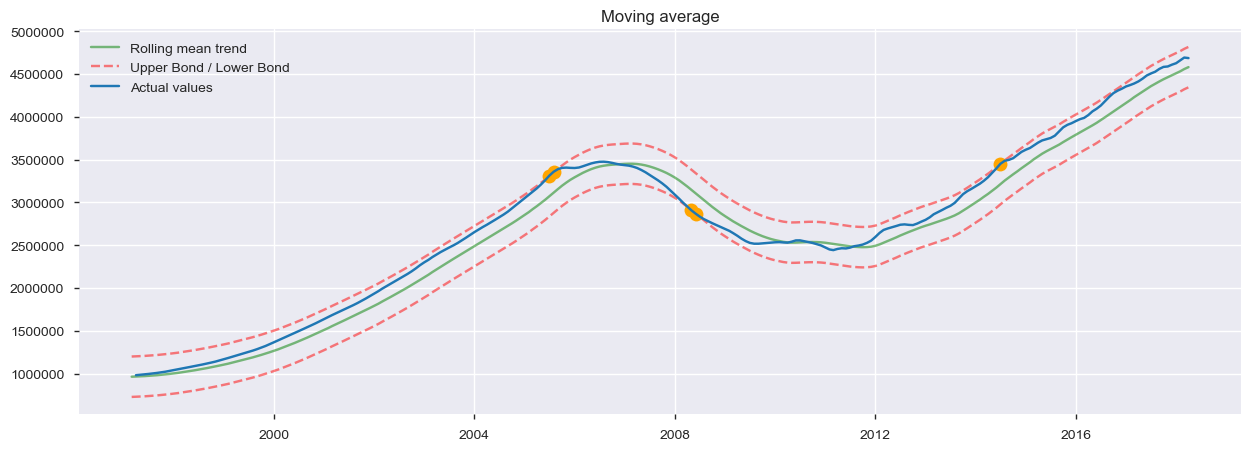

In [66]:
plot_moving_avg(zip_4, 12, scale=1)

This zip codes experiences a brief decrease anomaly around 2008, which hasn't been seen in the previous zip codes, but isn't surprising. There's also less anomalies observed overall than the other zip codes. 

/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Janelle/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimizat

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -2969.660
Date:                Thu, 24 Oct 2019   AIC                           5949.319
Time:                        23:09:14   BIC                           5967.199
Sample:                             0   HQIC                          5956.504
                                - 265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    744.4944    304.979      2.441      0.015     146.747    1342.242
ar.L1          0.9303      0.022     41.624      0.000       0.886       0.974
ma.L1         -0.8813      0.024    -36.430      0.0

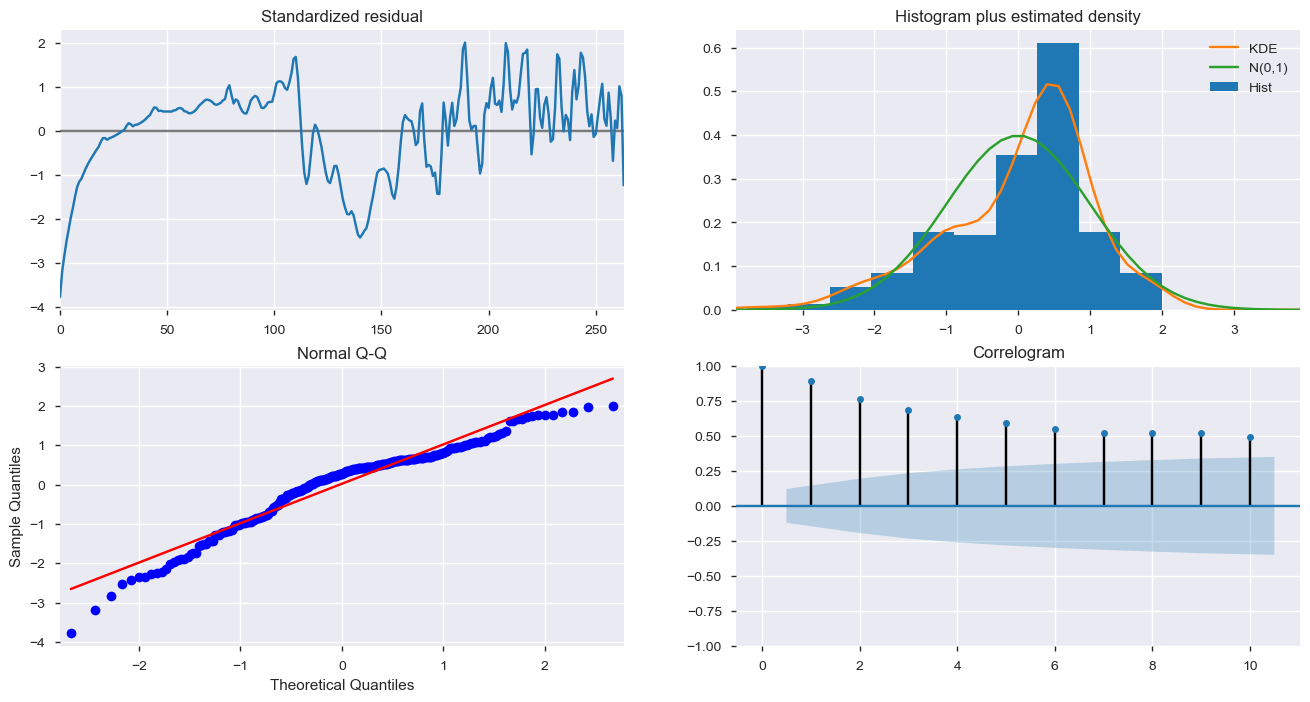

In [67]:
arima_results(zip_4)

The autocorrelation shows to be more positive in this model, but the residuals look a little different. Hopefully this doesn't mean it's a weak model. 

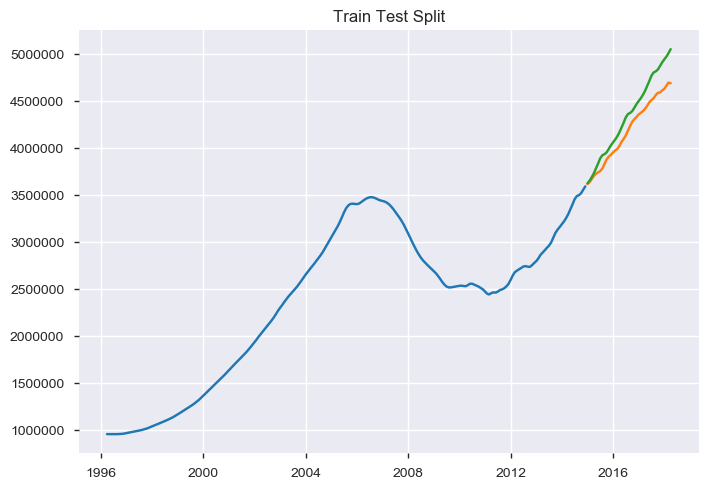

square root mean error: 186977.62986471367
MSE percent: 3.6264795803845082
explained variance score: 0.9551564308274557


In [68]:
auto_arima_tts(zip_4, .85)

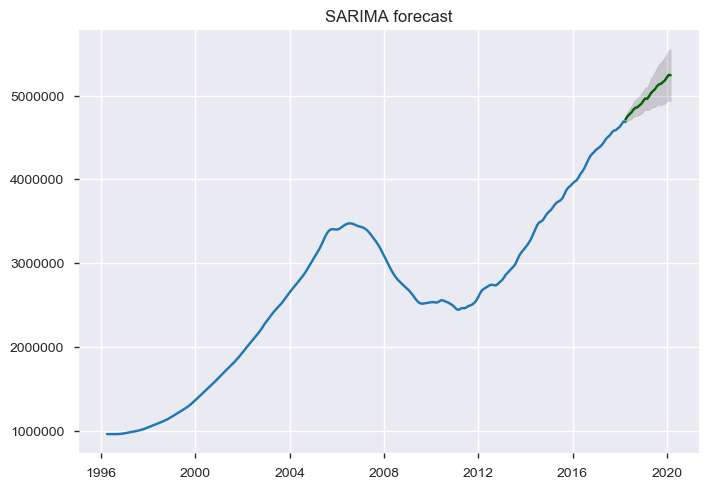

In [69]:
auto_sarima(zip_4)

## zip 94022

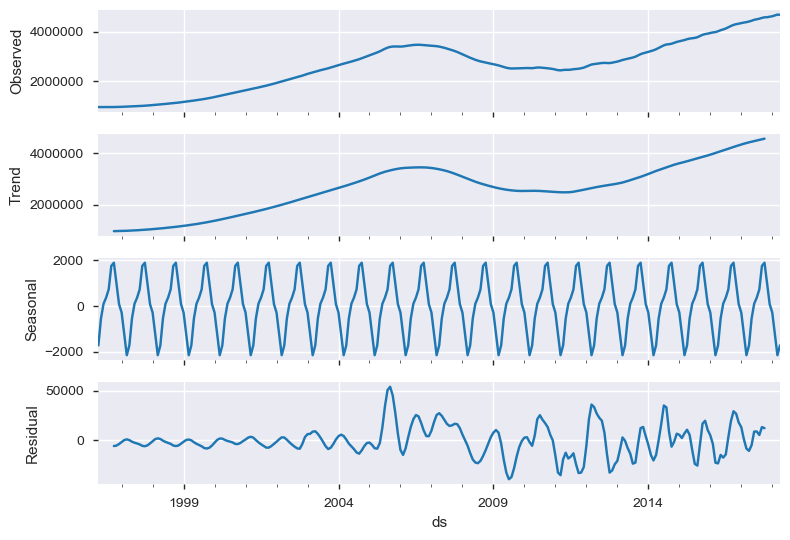

In [70]:
seasonal_decompose(zip_4).plot();

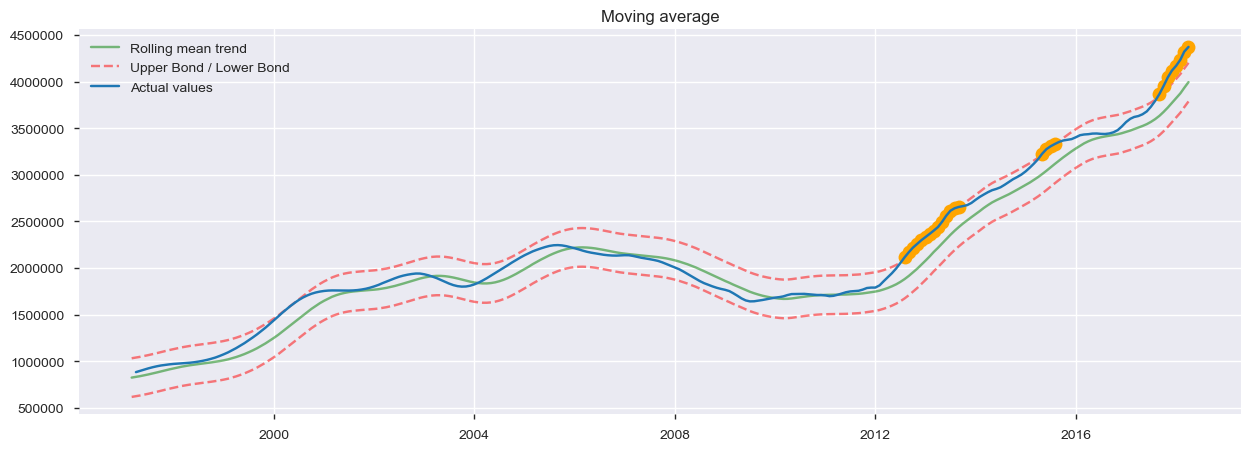

In [71]:
plot_moving_avg(zip_5, 12, scale=1)

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2689.235
Date:                Thu, 24 Oct 2019   AIC                           5382.470
Time:                        23:09:36   BIC                           5389.614
Sample:                             0   HQIC                          5385.341
                                - 265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    182.1293    419.528      0.434      0.664    -640.130    1004.388
sigma2      4.457e+07   2.14e+06     20.808      0.000    4.04e+07    4.88e+07
Ljung-Box (Q):                      137.10   Jarque-

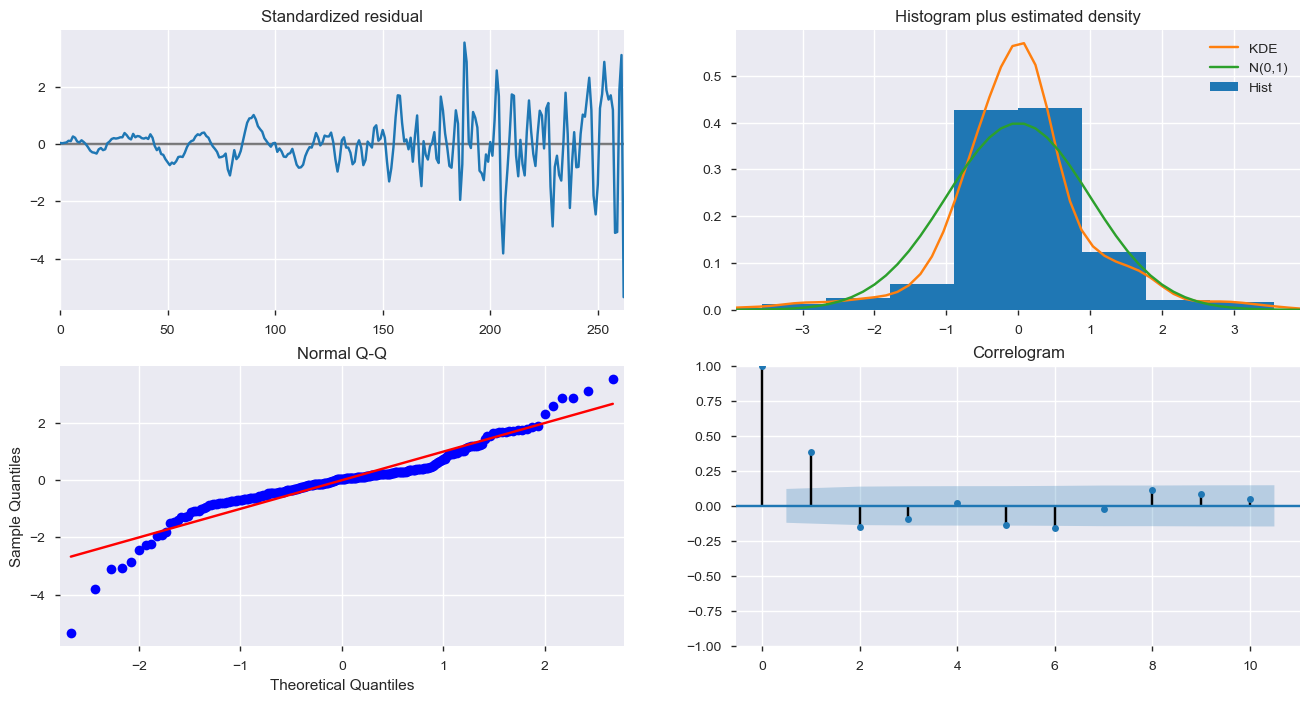

In [72]:
arima_results(zip_5)

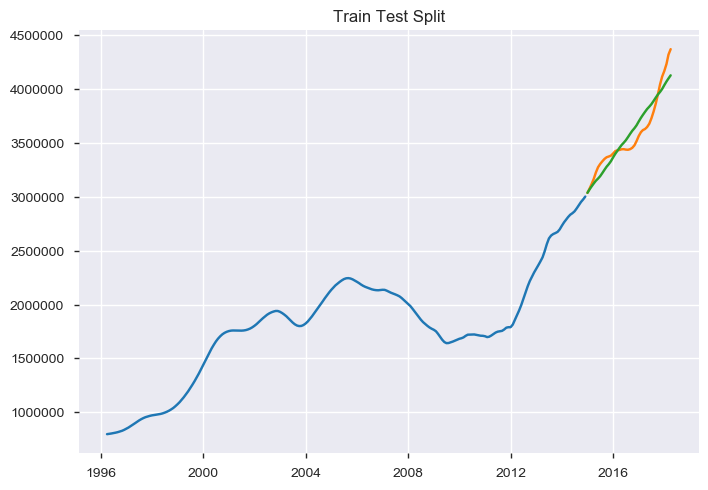

square root mean error: 114623.99065178494
MSE percent: 2.666512702212995
explained variance score: 0.8736292846404772


In [73]:
auto_arima_tts(zip_5, .85)

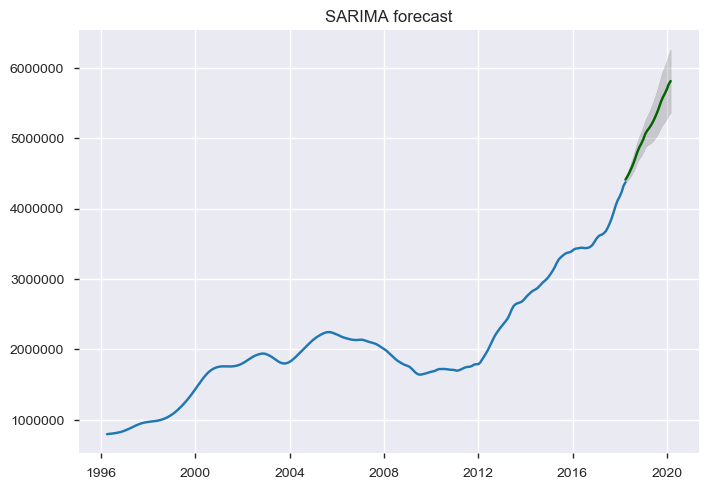

In [74]:
auto_sarima(zip_5)

# fbprophet

In [75]:
#stop

In [76]:
# imports for fbprophet
import fbprophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_plotly, plot_yearly, plot_cross_validation_metric
import plotly.offline as py
py.init_notebook_mode()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Facebook prophet is also often used to forecast time series data, and with le. 

## 94027

In [77]:
fb_proph(zip_1)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


6.79M is the average price in April 2018, and in 3 years it's predicted to be 8.28M. The 95% prediction interval is between 7.45M and 9.24M. You could expect between a 660K to 2.45M return on a home if bought at average market price for the area in 2018 and sold 3 years later.

INFO:fbprophet:Making 15 forecasts with cutoffs between 2002-04-05 00:00:00 and 2016-04-01 00:00:00


9.528836273356017


horizon           mse           rmse            mae      mape  coverage
1    89 days  4.471170e+10  211451.420202  181873.733106  0.049659  0.083333
2    90 days  5.904865e+10  242999.275880  206557.224841  0.054836  0.111111
3    91 days  6.009456e+10  245141.923184  209105.838346  0.054638  0.111111
4   118 days  5.759145e+10  239982.183068  203457.566110  0.053147  0.104167
5   119 days  5.025742e+10  224181.656976  188340.201345  0.050075  0.111111
6   120 days  5.339225e+10  231067.634307  198905.724980  0.054070  0.111111
7   121 days  6.960910e+10  263835.373715  224793.339976  0.059373  0.138889
8   122 days  7.090349e+10  266277.101053  227662.978484  0.059162  0.138889
9   149 days  6.765509e+10  260105.928118  220814.658624  0.057359  0.159722
10  150 days  5.823940e+10  241328.412625  202649.632533  0.053646  0.166667
11  151 days  6.138954e+10  247769.119884  212353.079256  0.057436  0.152778
13  153 days  8.161837e+10  285689.296304  243177.677389  0.062828  0.166667
14  179 days  7.776852e+10  278870.084612  235532.481729  0.060827  0.187500
15  180 days  6.666067e+10  258187.282897  215050.121612  0.056655  0.194444
16  181 days  6.991280e+10  264410.283219  224235.559216  0.060333  0.208333
17  182 days  9.133597e+10  302218.418496  253578.293754  0.066246  0.194444
18  183 days  9.318807e+10  305267.205451  257177.732682  0.066054  0.194444
19  210 days  8.878405e+10  297966.517884  248962.067552  0.063920  0.215278
20  211 days  7.597151e+10  275629.295451  227406.791342  0.059636  0.222222
21  212 days  7.998714e+10  282819.974234  237097.740306  0.063504  0.208333
22  213 days  1.028664e+11  320727.999390  266457.419976  0.069405  0.194444
23  214 days  1.049769e+11  324001.339825  270437.451581  0.069250  0.194444
25  241 days  8.513144e+10  291772.930004  239572.597420  0.062728  0.222222
26  242 days  9.015145e+10  300252.315659  249923.691141  0.066836  0.208333
27  243 days  1.142994e+11  338081.981333  278263.962128  0.072535  0.208333
28  244 days  1.166184e+11  341494.429407  282589.196254  0.072413  0.201389
29  271 days  1.107708e+11  332822.419101  274167.940373  0.070267  0.222222
30  272 days  9.381555e+10  306293.235857  250960.246323  0.065888  0.250000
31  273 days  9.949749e+10  315432.230294  261451.716933  0.070123  0.236111
32  274 days  1.263411e+11  355444.972965  290432.686466  0.075834  0.236111
..       ...           ...            ...            ...       ...       ...
75  545 days  2.800615e+11  529208.396148  434600.927466  0.111583  0.347222
76  546 days  2.832962e+11  532255.744509  438458.381304  0.115116  0.361111
77  547 days  3.834274e+11  619215.181580  513976.280112  0.130531  0.305556
78  548 days  3.800123e+11  616451.362891  509112.605008  0.126928  0.333333
79  575 days  3.621101e+11  601755.828317  496611.001683  0.124530  0.333333
80  576 days  3.033633e+11  550784.228092  449676.069985  0.115000  0.375000
81  577 days  3.073329e+11  554376.115488  454138.127839  0.118746  0.388889
82  578 days  4.132986e+11  642883.064437  531129.338564  0.134325  0.333333
83  579 days  4.086866e+11  639286.023176  524373.219027  0.130327  0.361111
85  606 days  3.246859e+11  569812.122856  461336.674456  0.117842  0.402778
86  607 days  3.293762e+11  573913.096470  466532.418212  0.121855  0.416667
87  608 days  4.398310e+11  663197.587344  544000.635821  0.137446  0.361111
88  609 days  4.338623e+11  658682.226658  534324.530363  0.132931  0.388889
89  636 days  4.119879e+11  641862.848480  520256.935100  0.130259  0.416667
90  637 days  3.419825e+11  584792.688522  468092.774655  0.119978  0.444444
91  638 days  3.470509e+11  589110.232131  473479.223675  0.124089  0.472222
92  639 days  4.666574e+11  683123.284815  553796.211565  0.140022  0.416667
93  640 days  4.597842e+11  678073.887941  541947.616364  0.135062  0.444444
94  667 days  4.361860e+11  660443.755922  527187.442600  0.132220  0.472222
95  668 days  3.633378e+11  602775.078580  475292.254957  0.122140  0.500000
9

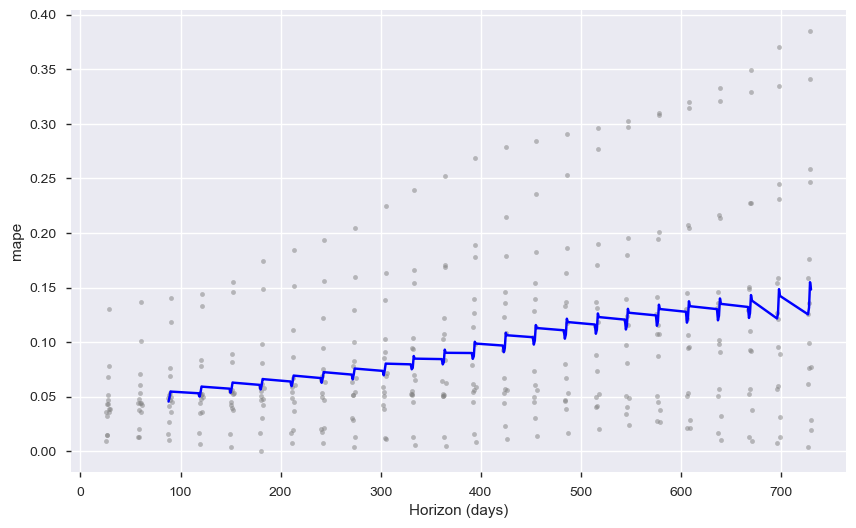

In [78]:
proph_metrics(m)

As with all forecasts, the further into the unknown the prediction, the larger the error. It still keeps below 10%, though, which means the forecast has a pretty good shot at being valid.

In [79]:
zip_1.tail(1)

y
ds                   
2018-04-01  6796500.0

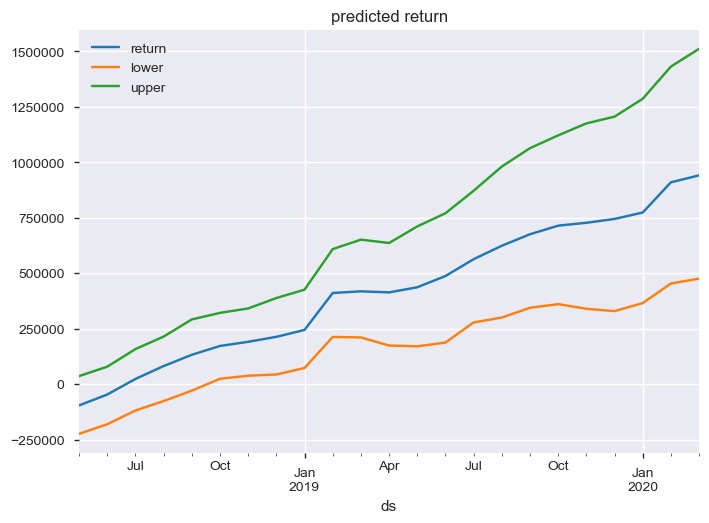

In [80]:
pred_return(6796500, preds)

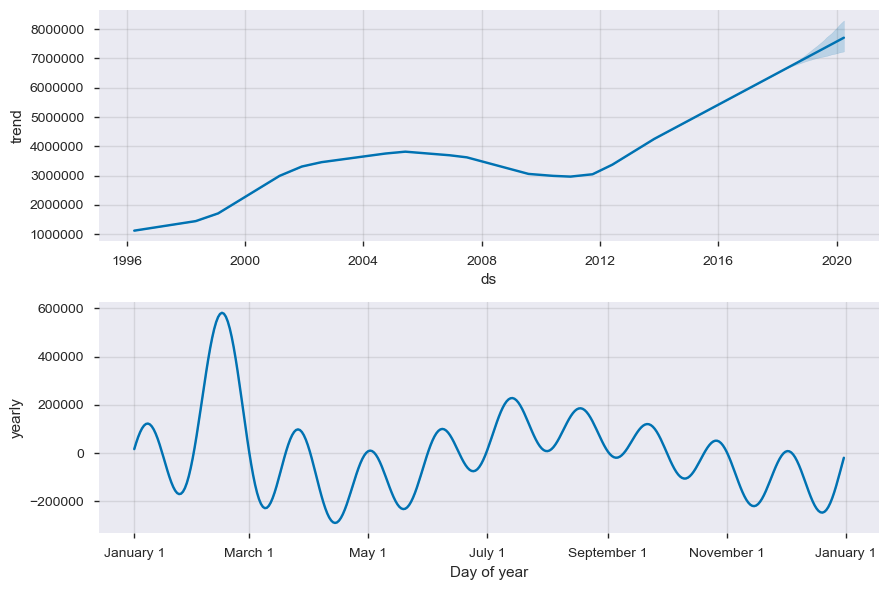

In [81]:
m.plot_components(forecast);

The trend is pretty clear at this point, but the yearly shows that the values rise to nearly 600k more than average in February, but then immediately dips below average between March and May. July to September also tend to sell up to 200k above average. 

From the gathered data, April is the best time to buy, and February would be the best time to sell, potentially making 600k more than other months of the year. 

## 90210

In [82]:
fb_proph(zip_2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2002-04-05 00:00:00 and 2016-04-01 00:00:00


12.887386884113406


horizon           mse           rmse            mae      mape  coverage
1    89 days  4.253318e+10  206235.747001  160117.611101  0.055812  0.277778
2    90 days  4.918944e+10  221786.932794  169343.260725  0.057514  0.319444
3    91 days  4.776797e+10  218558.854428  163965.852575  0.055439  0.340278
4   118 days  4.496027e+10  212038.363496  155893.855066  0.053038  0.347222
5   119 days  4.487446e+10  211835.934848  159859.660799  0.054537  0.277778
6   120 days  5.299216e+10  230200.255816  181124.636638  0.063164  0.250000
7   121 days  6.014529e+10  245245.365046  189151.663201  0.064256  0.291667
8   122 days  5.833817e+10  241532.967937  183292.278573  0.061928  0.312500
9   149 days  5.469247e+10  233864.220303  174344.440109  0.059263  0.319444
10  150 days  5.460724e+10  233681.930339  179822.137840  0.061245  0.250000
11  151 days  6.330019e+10  251595.288178  201662.829971  0.070194  0.222222
13  153 days  6.893042e+10  262546.032678  202535.537289  0.068227  0.305556
14  179 days  6.462356e+10  254211.640262  192648.521143  0.065309  0.319444
15  180 days  6.490851e+10  254771.491308  198763.460026  0.067632  0.250000
16  181 days  7.400414e+10  272037.019973  220913.414757  0.076811  0.222222
17  182 days  8.197992e+10  286321.356140  227328.556196  0.076909  0.277778
18  183 days  7.965318e+10  282228.956655  220438.104162  0.074105  0.305556
19  210 days  7.479137e+10  273480.099893  209936.816550  0.071007  0.319444
20  211 days  7.593094e+10  275555.690961  217409.035474  0.073890  0.250000
21  212 days  8.532892e+10  292111.137911  239814.596095  0.083274  0.222222
22  213 days  9.358574e+10  305917.861576  245654.098449  0.082921  0.277778
23  214 days  9.097399e+10  301618.955313  237903.264519  0.079818  0.305556
25  241 days  8.796342e+10  296586.276900  236103.008885  0.080182  0.250000
26  242 days  9.792173e+10  312924.485608  259106.473845  0.089886  0.222222
27  243 days  1.062724e+11  325994.509627  264184.752019  0.089039  0.277778
28  244 days  1.033815e+11  321529.934017  255788.956825  0.085691  0.305556
29  271 days  9.746221e+10  312189.389399  244382.278997  0.082360  0.319444
30  272 days  1.012985e+11  318274.243004  254970.905424  0.086540  0.250000
31  273 days  1.120908e+11  334799.621836  278921.005208  0.096679  0.222222
32  274 days  1.199283e+11  346306.665943  283289.232507  0.095344  0.277778
..       ...           ...            ...            ...       ...       ...
75  545 days  3.239866e+11  569198.168011  466558.635817  0.154767  0.222222
76  546 days  3.748236e+11  612228.351156  515873.441321  0.175669  0.194444
77  547 days  4.062028e+11  637340.395743  539600.788085  0.177597  0.222222
78  548 days  3.783541e+11  615104.915597  506386.739375  0.163866  0.277778
79  575 days  3.658165e+11  604827.627863  496021.358697  0.161958  0.270833
80  576 days  3.553793e+11  596136.958848  488084.136035  0.161513  0.277778
81  577 days  4.069052e+11  637891.225726  536535.370465  0.182260  0.250000
82  578 days  4.395862e+11  663012.974578  560788.305240  0.183884  0.277778
83  579 days  4.098733e+11  640213.482805  525553.580432  0.169550  0.333333
85  606 days  3.874530e+11  622457.205595  507641.968761  0.167714  0.333333
86  607 days  4.399305e+11  663272.596708  555698.781671  0.188468  0.291667
87  608 days  4.738627e+11  688376.833559  580550.766759  0.189827  0.277778
88  609 days  4.425767e+11  665264.384833  545096.107365  0.175252  0.333333
89  636 days  4.281156e+11  654305.457730  534072.187218  0.173278  0.326389
90  637 days  4.206470e+11  648573.021748  526975.438854  0.173809  0.333333
91  638 days  4.749028e+11  689131.941487  575628.082547  0.194829  0.277778
92  639 days  5.103295e+11  714373.467010  601576.527689  0.196041  0.277778
93  640 days  4.775202e+11  691028.355669  565985.370818  0.181248  0.333333
94  667 days  4.621491e+11  679815.500837  554693.158363  0.179267  0.326389
95  668 days  4.568184e+11  675883.405313  548234.236289  0.180388  0.333333
9

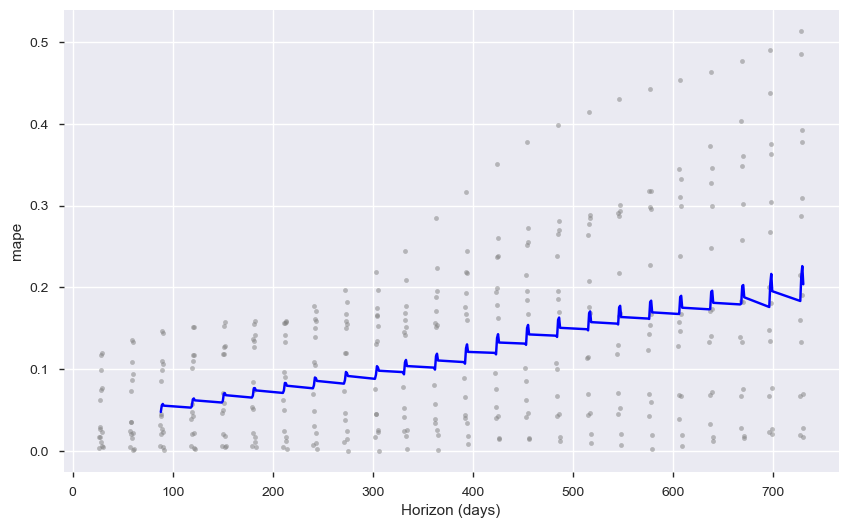

In [83]:
proph_metrics(m)

In [84]:
zip_2.tail(1)

y
ds                   
2018-04-01  5956700.0

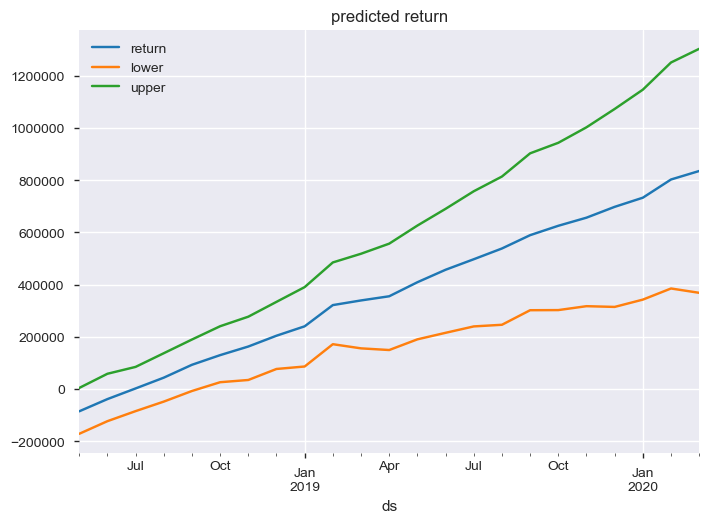

In [85]:
pred_return(5956700, preds)

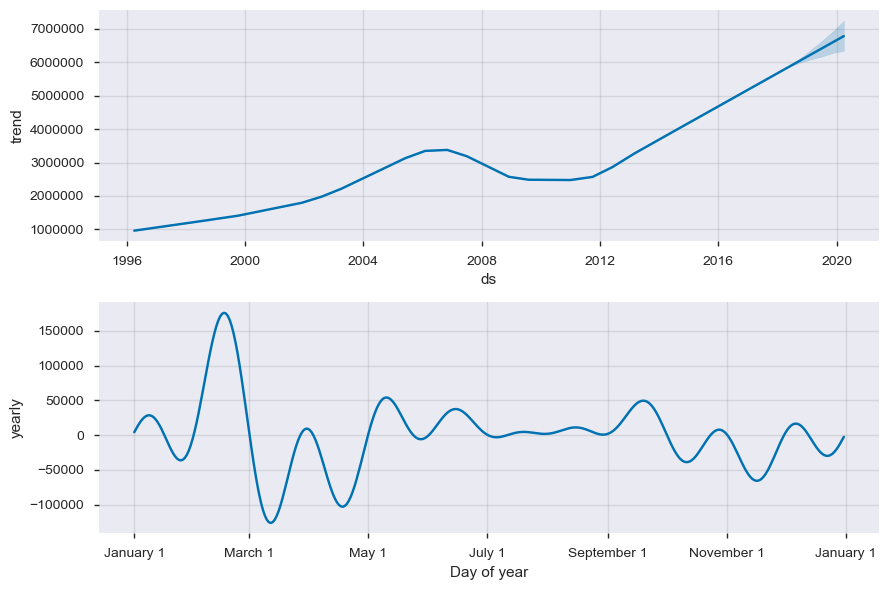

In [86]:
m.plot_components(forecast);

## 94301

In [87]:
fb_proph(zip_3)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2002-04-05 00:00:00 and 2016-04-01 00:00:00


13.977895515563704


horizon           mse           rmse            mae      mape  coverage
1    89 days  3.433311e+10  185291.970401  145713.344228  0.068679  0.222222
2    90 days  4.616207e+10  214853.611074  164251.256765  0.074111  0.277778
3    91 days  4.769100e+10  218382.683209  168232.137575  0.074063  0.277778
4   118 days  4.511249e+10  212397.004060  159997.588866  0.070488  0.291667
5   119 days  4.017382e+10  200434.076994  150029.649946  0.068642  0.277778
6   120 days  4.277791e+10  206828.206911  160328.817864  0.074663  0.263889
7   121 days  5.601049e+10  236665.353555  179375.341355  0.079875  0.305556
8   122 days  5.768910e+10  240185.542942  183422.398713  0.079698  0.305556
9   149 days  5.432622e+10  233079.861843  173933.405939  0.075609  0.319444
10  150 days  4.742981e+10  217783.855374  161738.851404  0.073384  0.305556
11  151 days  5.015048e+10  223943.030727  171355.635054  0.078993  0.291667
13  153 days  6.664396e+10  258154.919477  195536.106329  0.083986  0.333333
14  179 days  6.258476e+10  250169.470931  185160.737973  0.079522  0.375000
15  180 days  5.420013e+10  232809.215631  172521.400558  0.077522  0.361111
16  181 days  5.713634e+10  239032.092572  182902.005965  0.083599  0.347222
17  182 days  7.368933e+10  271457.782690  204441.326376  0.089098  0.375000
18  183 days  7.564350e+10  275033.636299  208864.789915  0.088887  0.368056
19  210 days  7.098688e+10  266433.631388  197644.772947  0.084085  0.402778
20  211 days  6.169278e+10  248380.306369  185123.085479  0.082558  0.388889
21  212 days  6.492000e+10  254794.040571  196378.693876  0.089213  0.375000
22  213 days  8.338943e+10  288772.279354  219155.006971  0.094881  0.402778
23  214 days  8.532798e+10  292109.530243  223671.770517  0.094683  0.395833
25  241 days  6.999529e+10  264566.231766  199199.882629  0.088461  0.416667
26  242 days  7.333908e+10  270811.886496  210936.085168  0.095517  0.347222
27  243 days  9.389702e+10  306426.212449  234477.540803  0.100989  0.375000
28  244 days  9.555636e+10  309121.912874  238439.193778  0.100531  0.368056
29  271 days  8.961095e+10  299350.873522  224940.591565  0.094721  0.402778
30  272 days  7.858989e+10  280338.891848  212984.722039  0.094325  0.361111
31  273 days  8.204863e+10  286441.315991  225185.814033  0.101779  0.291667
32  274 days  1.048902e+11  323867.632052  249497.507040  0.106925  0.291667
..       ...           ...            ...            ...       ...       ...
75  545 days  2.271887e+11  476643.139739  401759.265327  0.171501  0.194444
76  546 days  2.309311e+11  480552.861791  409763.287261  0.180217  0.180556
77  547 days  2.943076e+11  542501.207814  456796.556759  0.190386  0.166667
78  548 days  2.934033e+11  541667.109203  455755.274249  0.184277  0.194444
79  575 days  2.766313e+11  525957.520311  436606.743079  0.177530  0.222222
80  576 days  2.422241e+11  492162.726392  412175.881848  0.175727  0.250000
81  577 days  2.461663e+11  496151.464545  419892.092089  0.184291  0.236111
82  578 days  3.135952e+11  559995.741144  468116.480174  0.194368  0.236111
83  579 days  3.118140e+11  558403.122811  465565.656448  0.187771  0.250000
85  606 days  2.579535e+11  507891.247538  421655.381260  0.179543  0.305556
86  607 days  2.618241e+11  511687.492182  428989.902209  0.187887  0.319444
87  608 days  3.342141e+11  578112.551749  479090.474115  0.198003  0.291667
88  609 days  3.315410e+11  575795.995315  475261.596758  0.190992  0.305556
89  636 days  3.123467e+11  558879.848328  454719.696181  0.183822  0.333333
90  637 days  2.748651e+11  524275.775488  431779.132484  0.183568  0.347222
91  638 days  2.785562e+11  527784.199932  438828.970427  0.191727  0.347222
92  639 days  3.569824e+11  597480.032590  491378.316135  0.201993  0.319444
93  640 days  3.535153e+11  594571.492904  486643.923835  0.194680  0.333333
94  667 days  3.330829e+11  577133.323126  466165.384002  0.187777  0.354167
95  668 days  2.942682e+11  542464.962688  444193.471070  0.188433  0.347222
9

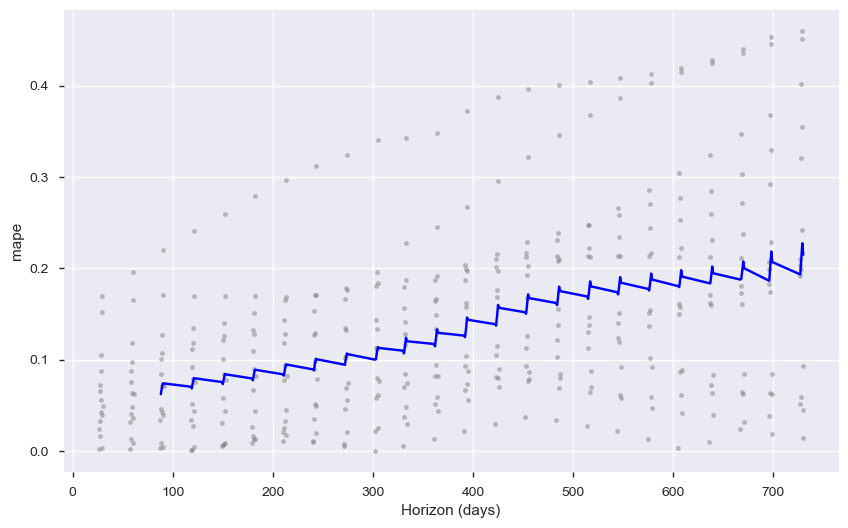

In [88]:
proph_metrics(m)

In [89]:
zip_3.tail(1)

y
ds                   
2018-04-01  4818400.0

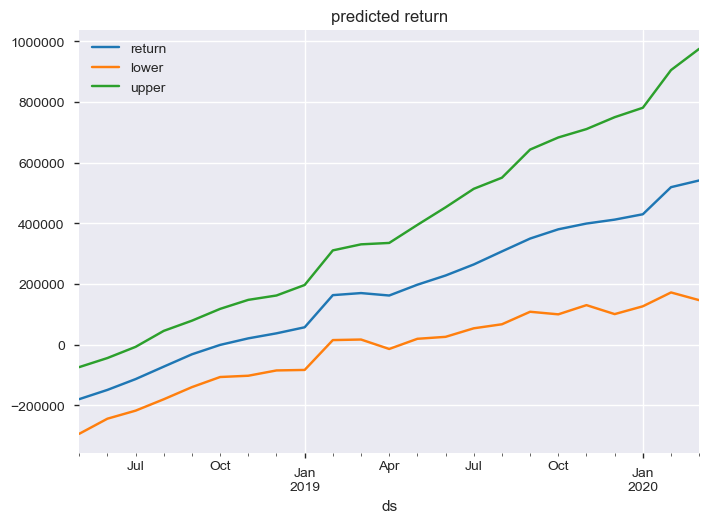

In [90]:
pred_return(4818400, preds)

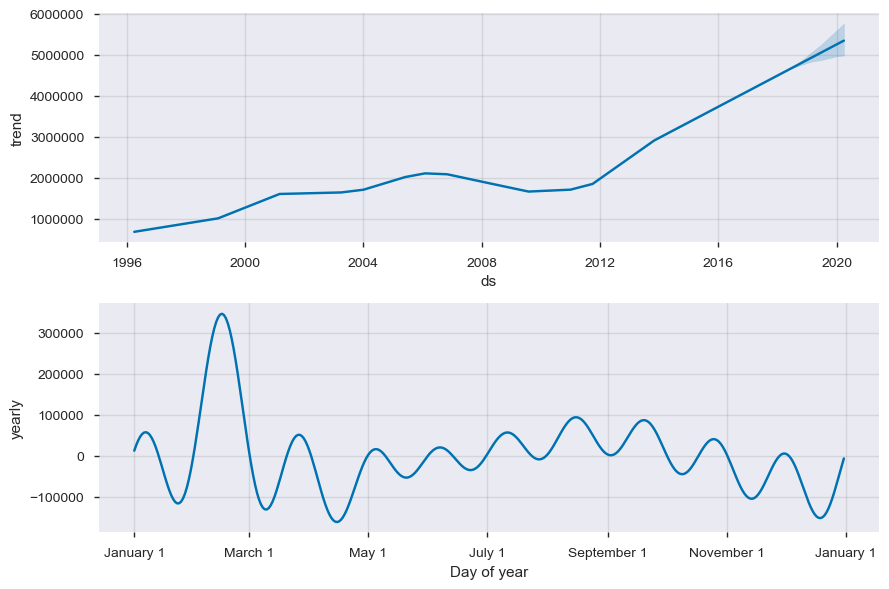

In [91]:
m.plot_components(forecast);

## 33480

In [92]:
fb_proph(zip_4)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2002-04-05 00:00:00 and 2016-04-01 00:00:00


11.182328206180717


horizon           mse           rmse            mae      mape  coverage
1    89 days  3.085466e+10  175654.946345  136487.708078  0.046754  0.250000
2    90 days  3.296379e+10  181559.321096  143518.769782  0.048728  0.263889
3    91 days  3.196288e+10  178781.662164  139382.899413  0.047128  0.284722
4   118 days  3.010077e+10  173495.721124  131056.140273  0.044299  0.305556
5   119 days  3.265624e+10  180710.380077  135565.707859  0.045229  0.305556
6   120 days  3.812543e+10  195257.332773  152092.842360  0.052045  0.319444
7   121 days  3.990611e+10  199765.146325  158299.452865  0.053656  0.319444
8   122 days  3.866365e+10  196630.748877  154192.127765  0.051982  0.340278
9   149 days  3.634980e+10  190656.233636  145189.132830  0.048927  0.354167
10  150 days  3.974795e+10  199368.884734  150895.746457  0.050242  0.333333
11  151 days  4.547586e+10  213250.708498  168346.167505  0.057569  0.319444
13  153 days  4.528869e+10  212811.390124  170081.976797  0.057182  0.312500
14  179 days  4.252137e+10  206207.097110  160407.732964  0.053902  0.326389
15  180 days  4.697209e+10  216730.447378  167099.123235  0.055592  0.305556
16  181 days  5.293291e+10  230071.537835  185398.465114  0.063398  0.263889
17  182 days  5.392295e+10  232213.160086  190580.081973  0.064381  0.236111
18  183 days  5.232273e+10  228741.620853  186448.754558  0.062529  0.256944
19  210 days  4.921425e+10  221842.840444  176142.965026  0.059033  0.270833
20  211 days  5.529286e+10  235144.335318  183406.733772  0.061026  0.250000
21  212 days  6.156960e+10  248132.225250  202645.633934  0.069324  0.208333
22  213 days  6.259985e+10  250199.628050  207509.716475  0.070037  0.180556
23  214 days  6.080167e+10  246579.948065  202825.411469  0.067954  0.201389
25  241 days  6.566488e+10  256251.598591  199289.508537  0.066452  0.250000
26  242 days  7.253600e+10  269325.075694  219958.130146  0.075398  0.208333
27  243 days  7.342174e+10  270964.466552  224203.571181  0.075751  0.222222
28  244 days  7.138141e+10  267172.987354  218777.271428  0.073394  0.250000
29  271 days  6.757157e+10  259945.320020  206806.341876  0.069328  0.305556
30  272 days  7.818598e+10  279617.560839  215493.847910  0.072119  0.333333
31  273 days  8.592056e+10  293122.083522  238036.137050  0.081842  0.291667
32  274 days  8.630870e+10  293783.429650  241589.482354  0.081799  0.305556
..       ...           ...            ...            ...       ...       ...
75  545 days  2.473533e+11  497346.285037  386903.982801  0.129984  0.305556
76  546 days  2.974402e+11  545380.757697  442227.337829  0.152644  0.236111
77  547 days  3.032105e+11  550645.527482  458669.589379  0.155533  0.222222
78  548 days  2.780124e+11  527268.858946  429047.098945  0.143408  0.277778
79  575 days  2.695670e+11  519198.461918  416428.149927  0.139590  0.305556
80  576 days  2.721557e+11  521685.407329  406290.355988  0.136196  0.333333
81  577 days  3.242985e+11  569472.128271  462037.213967  0.159207  0.263889
82  578 days  3.307280e+11  575089.558356  479213.029936  0.162020  0.250000
83  579 days  3.037354e+11  551121.910999  448303.009163  0.149386  0.305556
85  606 days  2.999124e+11  547642.547616  425231.227940  0.142388  0.361111
86  607 days  3.544597e+11  595365.220675  481532.305014  0.165794  0.291667
87  608 days  3.613369e+11  601113.076596  499278.970692  0.168498  0.277778
88  609 days  3.325948e+11  576710.291477  467570.686244  0.155488  0.333333
89  636 days  3.226682e+11  568038.940630  453836.624667  0.151392  0.361111
90  637 days  3.309019e+11  575240.766737  444093.646465  0.148714  0.388889
91  638 days  3.886711e+11  623434.960379  501595.191146  0.172669  0.305556
92  639 days  3.955419e+11  628921.208151  519783.239497  0.175203  0.277778
93  640 days  3.649362e+11  604099.493651  487381.687420  0.161836  0.333333
94  667 days  3.539901e+11  594970.684933  472864.106076  0.157528  0.361111
95  668 days  3.651064e+11  604240.317941  463536.018358  0.155298  0.388889
9

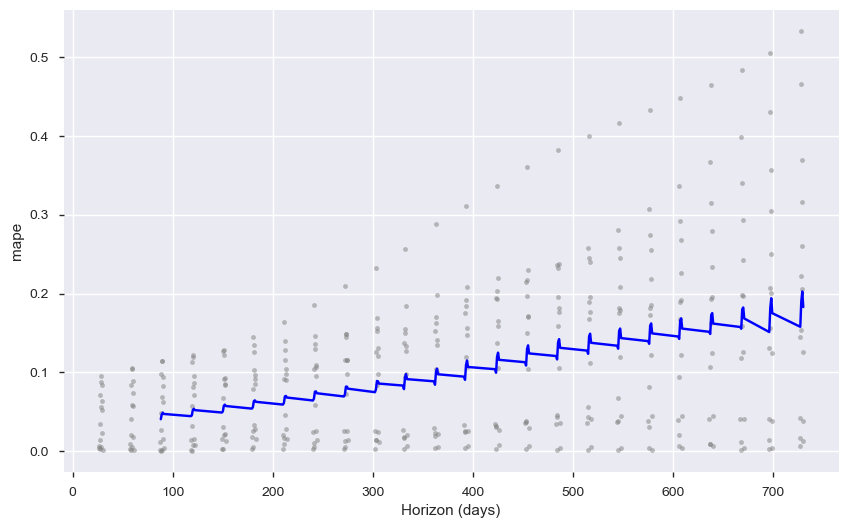

In [93]:
proph_metrics(m)

In [94]:
zip_4.tail(1)

y
ds                   
2018-04-01  4686200.0

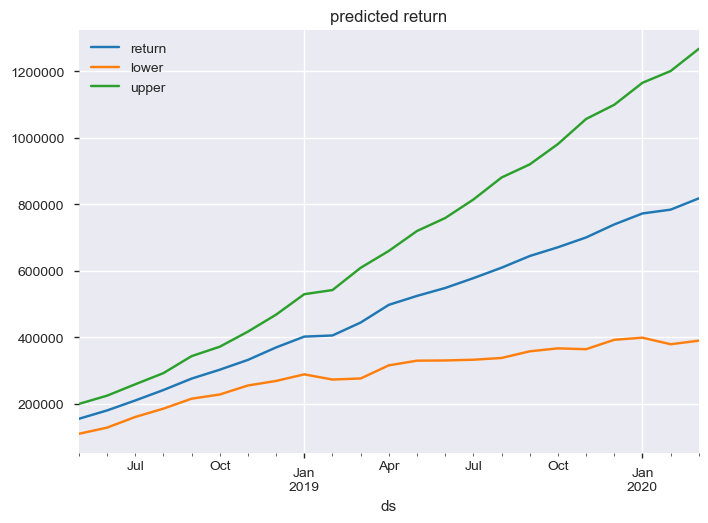

In [95]:
pred_return(4686200, preds)

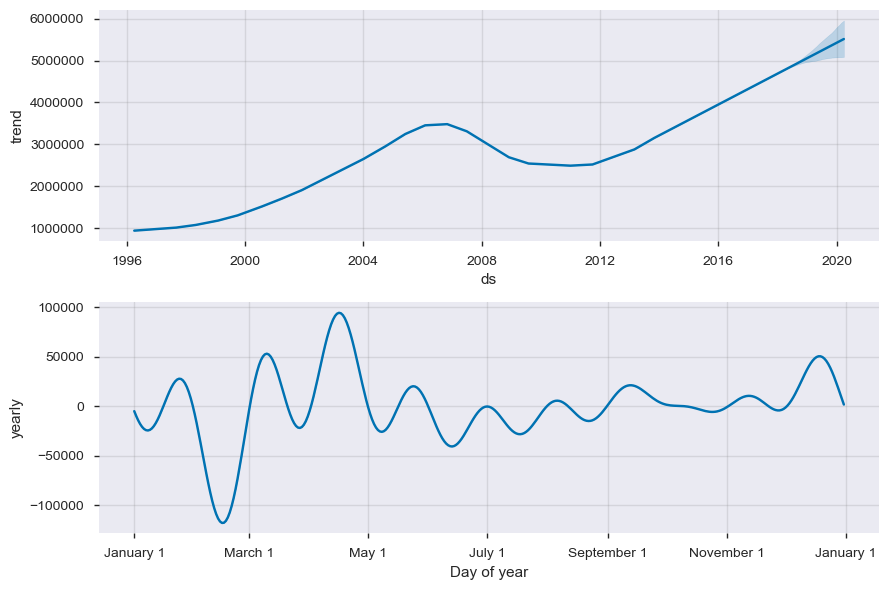

In [96]:
m.plot_components(forecast);

## 94022

In [97]:
fb_proph(zip_5)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 15 forecasts with cutoffs between 2002-04-05 00:00:00 and 2016-04-01 00:00:00


13.459295596028465


horizon           mse           rmse            mae      mape  coverage
1    89 days  3.010151e+10  173497.862599  153134.659114  0.073642  0.111111
2    90 days  3.862194e+10  196524.646177  166991.161369  0.077986  0.166667
3    91 days  3.964747e+10  199116.726096  170096.937397  0.077985  0.166667
4   118 days  3.883950e+10  197077.407910  168947.628428  0.077871  0.152778
5   119 days  3.739391e+10  193375.039795  168524.686397  0.079245  0.111111
6   120 days  3.826486e+10  195614.064352  170952.222650  0.081615  0.138889
7   121 days  4.804828e+10  219199.181335  184870.195081  0.085688  0.194444
8   122 days  4.939574e+10  222251.524787  188459.710331  0.085713  0.194444
9   149 days  4.816630e+10  219468.228371  186695.510349  0.085403  0.180556
10  150 days  4.564424e+10  213645.119887  184683.317394  0.086448  0.138889
11  151 days  4.614579e+10  214815.720932  185250.710040  0.087864  0.166667
13  153 days  5.852973e+10  241929.185220  202820.407554  0.091632  0.222222
14  179 days  5.685565e+10  238444.233671  200578.737506  0.091172  0.208333
15  180 days  5.318400e+10  230616.571610  197251.771917  0.091977  0.166667
16  181 days  5.346776e+10  231230.961005  196506.748868  0.092722  0.194444
17  182 days  6.514458e+10  255234.367100  210235.206785  0.096270  0.236111
18  183 days  6.687284e+10  258597.833808  214363.819374  0.096319  0.229167
19  210 days  6.478257e+10  254524.210294  211710.007579  0.095716  0.208333
20  211 days  6.021728e+10  245392.101394  207392.099889  0.096381  0.194444
21  212 days  6.045585e+10  245877.719773  205993.922096  0.096812  0.222222
22  213 days  7.296810e+10  270126.079110  220579.236020  0.100456  0.263889
23  214 days  7.474708e+10  273399.123493  224839.015521  0.100516  0.256944
25  241 days  6.701850e+10  258879.320063  216720.792295  0.100298  0.250000
26  242 days  6.715684e+10  259146.372432  215648.742974  0.101012  0.277778
27  243 days  8.081041e+10  284271.711158  231335.526049  0.104806  0.319444
28  244 days  8.244353e+10  287129.817046  235400.060474  0.104757  0.312500
29  271 days  7.936722e+10  281721.891544  231256.928784  0.103463  0.319444
30  272 days  7.378034e+10  271625.361033  225743.275185  0.104023  0.305556
31  273 days  7.384280e+10  271740.309670  225242.620932  0.105162  0.319444
32  274 days  8.890157e+10  298163.655440  242062.031768  0.109082  0.347222
..       ...           ...            ...            ...       ...       ...
75  545 days  1.913226e+11  437404.427682  360869.739911  0.157723  0.361111
76  546 days  1.976575e+11  444586.918482  372863.348176  0.168509  0.361111
77  547 days  2.445816e+11  494551.868014  414017.770148  0.179577  0.305556
78  548 days  2.413232e+11  491246.603439  409662.473097  0.173088  0.305556
79  575 days  2.284269e+11  477940.234959  394959.306048  0.167872  0.333333
80  576 days  2.023125e+11  449791.592997  368277.330335  0.161118  0.388889
81  577 days  2.095924e+11  457812.645468  380703.386088  0.172181  0.388889
82  578 days  2.589351e+11  508856.667104  422675.913816  0.183261  0.361111
83  579 days  2.548331e+11  504809.969600  416346.581334  0.176106  0.361111
85  606 days  2.125358e+11  461016.042017  372938.152632  0.163672  0.444444
86  607 days  2.208081e+11  469902.265712  386268.706020  0.175188  0.444444
87  608 days  2.733678e+11  522845.856284  429631.042373  0.186379  0.416667
88  609 days  2.683969e+11  518070.348714  421507.770279  0.178567  0.416667
89  636 days  2.535704e+11  503557.787496  405461.645960  0.172886  0.444444
90  637 days  2.234146e+11  472667.556975  376606.299328  0.165789  0.486111
91  638 days  2.326711e+11  482359.963238  390967.745855  0.177746  0.472222
92  639 days  2.895454e+11  538094.263539  436572.116809  0.189200  0.416667
93  640 days  2.837013e+11  532636.207197  427128.639406  0.180823  0.416667
94  667 days  2.680266e+11  517712.830311  410412.903698  0.174872  0.437500
95  668 days  2.365991e+11  486414.517021  381760.599878  0.168097  0.458333
9

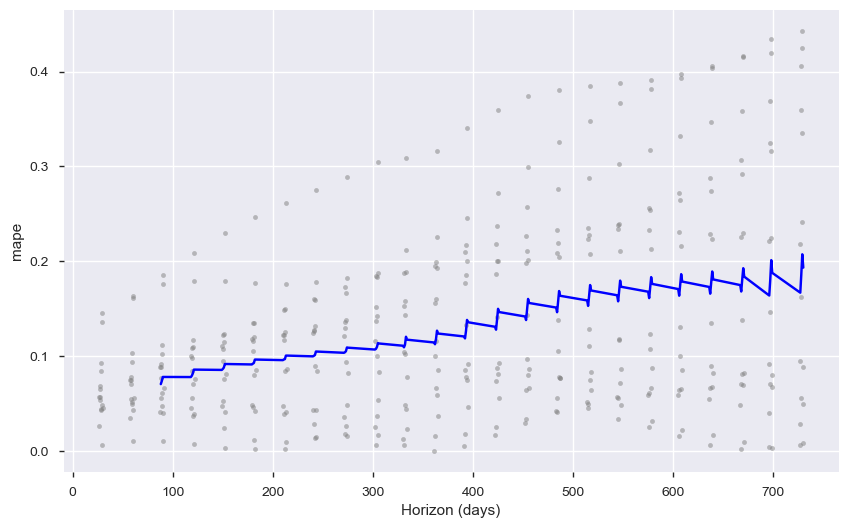

In [98]:
proph_metrics(m)

In [99]:
zip_5.tail(1)

y
ds                   
2018-04-01  4372600.0

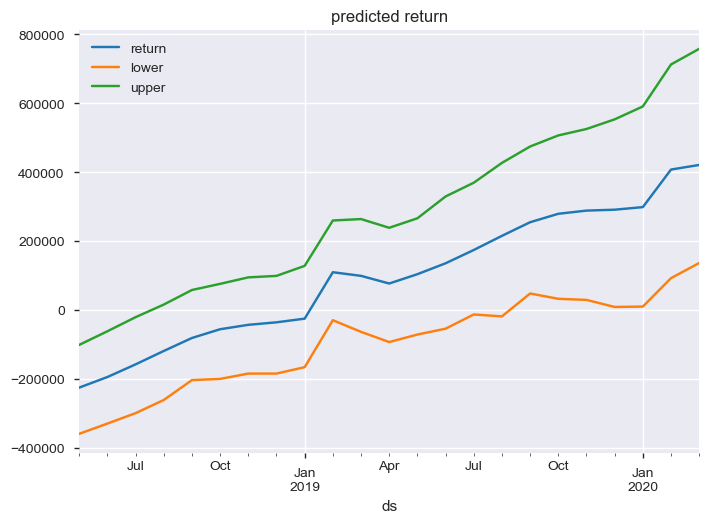

In [100]:
pred_return(4372600, preds)

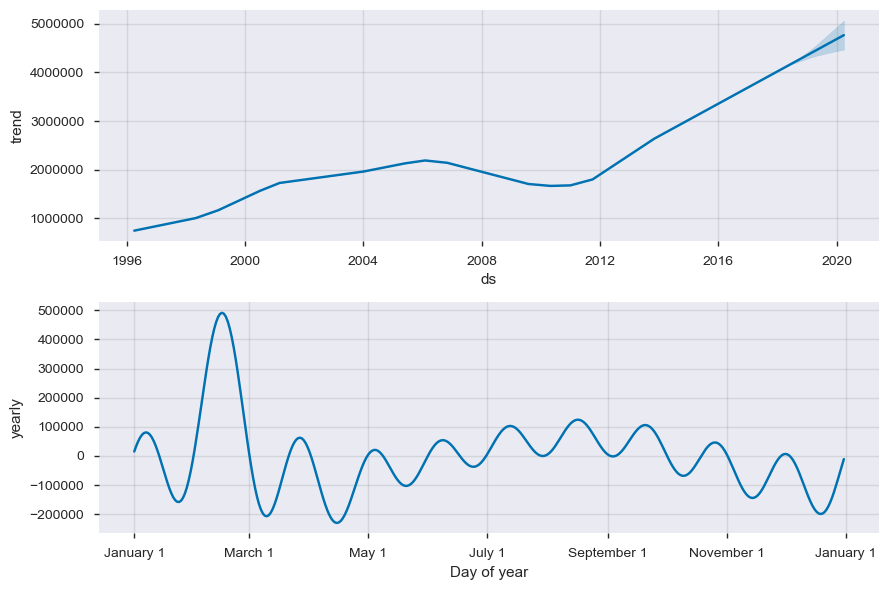

In [101]:
m.plot_components(forecast);

# conclusion